In [1]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
import re
import optuna

/home/thomasdev/anaconda3/envs/ultralytics-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  
torch.cuda.empty_cache()

In [3]:
from modules import (
    get_data_from_trajectory_id,
    create_simple_dataloader,
    Step_1,
    Step_2,
    CombinedHamiltonianLayer,
    SimpleStackedHamiltonianNetwork,
    ReverseStep2,
    ReverseStep1,
    ReverseCombinedHamiltonianLayer,
    InverseStackedHamiltonianNetwork,
    prediction_loss,
    prediction_loss_euclidean,
    load_checkpoint,
    count_parameters,
    hsic_loss_statistics_only,
    hsic_loss
    )

In [4]:
from modules import (    
    calculate_phi_A,
    add_phi_A_columns,
    plot_differencies,
    plot_prediction_vs_ground_truth,
    plot_distance_over_time,
    ensemble_autoregressive_prediction_mahalanobis,
    ensemble_autoregressive_prediction_gaussian_mixture,
    ensemble_autoregressive_prediction_gaussian_mixture_simple,
    test_model_in_single_trajectory,
    analyze_means_with_constants,
    visualize_trajectory_movements_with_std_ellipses,
    visualize_epoch_metrics,
    analyze_folders_means,
    analyze_mapping_net,
    test_model_in_all_trajectories_in_df,
    test_model_variance_in_all_trajectories_in_df,
    plot_prediction_losses,
    plot_variance_losses,
    test_model_with_varying_observed_points,
    test_model_variance_with_varying_observed_points,
    compute_jacobian_functional,
    compute_symplectic_product,
    check_canonical_transformation,
    test_canonical_tranformation_on_trajectory,
    test_model_in_all_trajectories_with_different_single_observation_in_df,
    )

In [5]:
save_dir_path = "./save_directory_noisy_full_pred_low_samples_pendulum_3" 


In [6]:
with open("all_dataframes_low_samples_pendulum.pkl", "rb") as f:
    loaded_dfs_low_samples_pendulum = pickle.load(f)

# Access them like before:
train_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['train_df_low_samples_pendulum']
val_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['val_df_low_samples_pendulum']
test_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['test_df_low_samples_pendulum']

train_id_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['train_id_df_low_samples_pendulum']
val_id_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['val_id_df_low_samples_pendulum']
test_id_df_low_samples_pendulum = loaded_dfs_low_samples_pendulum['test_id_df_low_samples_pendulum']

with open("df_high_energy_low_samples_pendulum.pkl", "rb") as f:
    df_high_energy_low_samples_pendulum = pickle.load(f)

val_df_high_energy_low_samples_pendulum = df_high_energy_low_samples_pendulum['val_df_high_energy_low_samples_pendulum']
val_id_df_high_energy_low_samples_pendulum = df_high_energy_low_samples_pendulum['val_id_df_high_energy_low_samples_pendulum']

test_df_high_energy_low_samples_pendulum = df_high_energy_low_samples_pendulum['test_df_high_energy_low_samples_pendulum']
test_id_df_high_energy_low_samples_pendulum = df_high_energy_low_samples_pendulum['test_id_df_high_energy_low_samples_pendulum']

with open("all_dataframes_low_samples_multiple_periods_pendulum.pkl", "rb") as f:
    df_low_samples_multiple_periods_pendulum = pickle.load(f)

test_df_low_samples_multiple_periods_pendulum = df_low_samples_multiple_periods_pendulum['data_df_low_samples_multiple_periods_pendulum']
test_id_df_low_samples_multiple_periods_pendulum = df_low_samples_multiple_periods_pendulum['id_df_low_samples_multiple_periods_pendulum']




📊 Metric summaries:
  Lowest loss of metric 'val_prediction_loss_' recorded in epoch 592 with the value: 0.0531, the losses of the last 5 epochs are: ['0.0587', '0.0584', '0.0579', '0.0556', '0.0596']
  Lowest loss of metric 'val_variance_loss_high_energy' recorded in epoch 453 with the value: 0.1513, the losses of the last 5 epochs are: ['0.2103', '0.2136', '0.2091', '0.1905', '0.1986']
  Lowest loss of metric 'val_prediction_loss_high_energy' recorded in epoch 530 with the value: 0.4057, the losses of the last 5 epochs are: ['0.4818', '0.4871', '0.4828', '0.4570', '0.4633']
  Lowest loss of metric 'val_variance_loss_training_set' recorded in epoch 592 with the value: 0.0019, the losses of the last 5 epochs are: ['0.0023', '0.0026', '0.0027', '0.0025', '0.0024']
  Lowest loss of metric 'val_prediction_loss_training_set' recorded in epoch 592 with the value: 0.0473, the losses of the last 5 epochs are: ['0.0489', '0.0541', '0.0535', '0.0539', '0.0532']
  Lowest loss of metric 'val_var

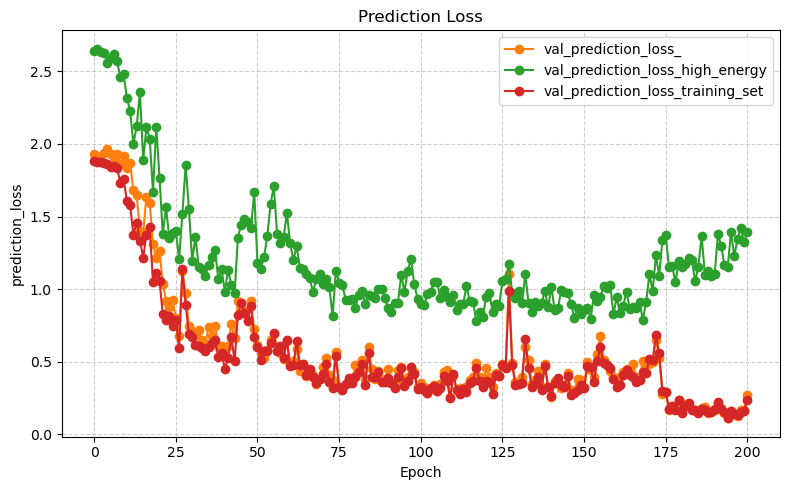

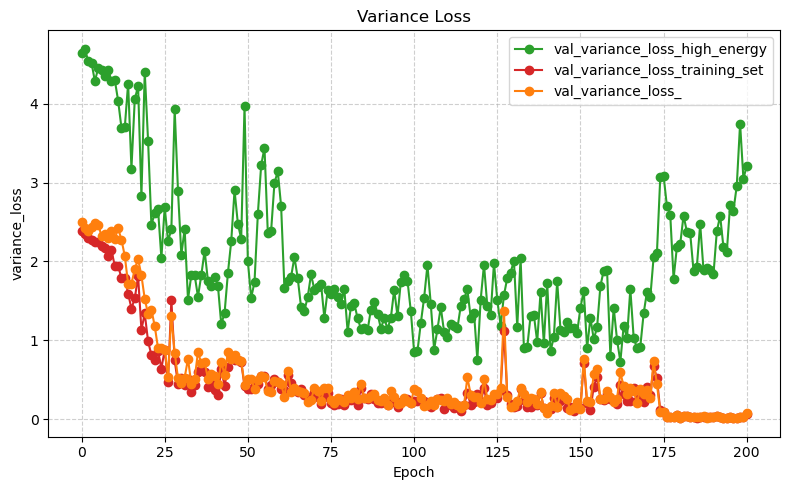

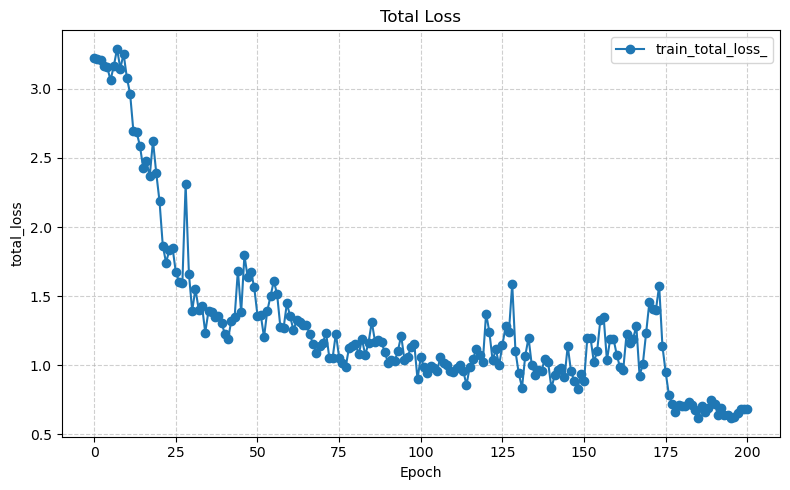

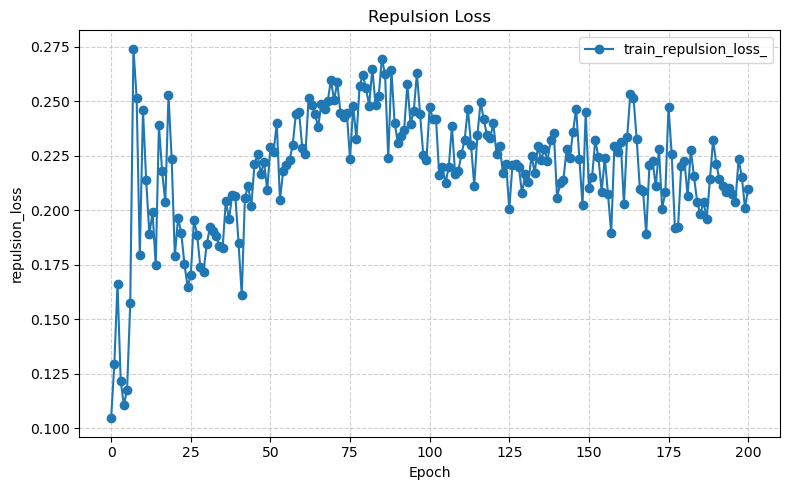

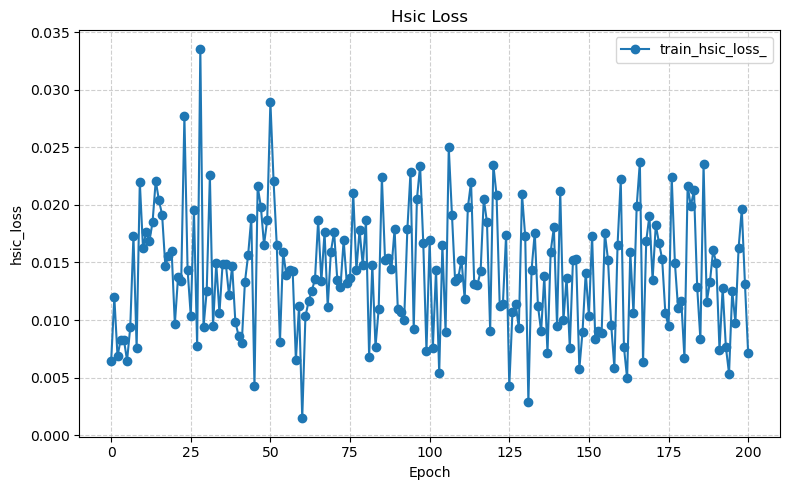

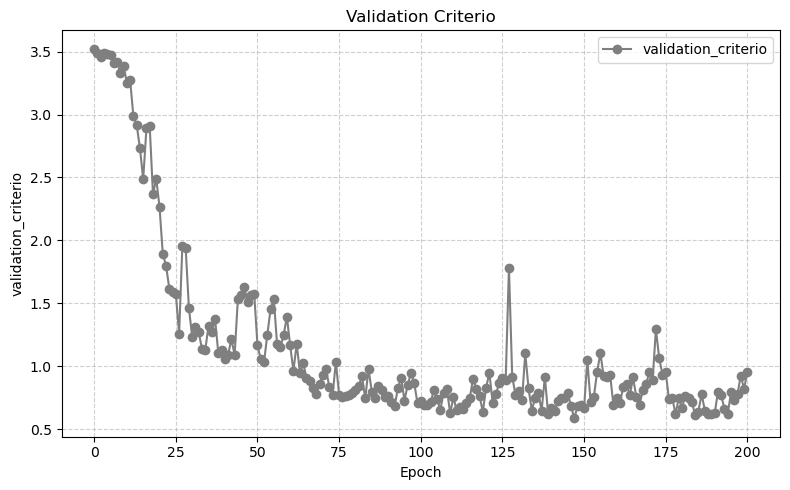

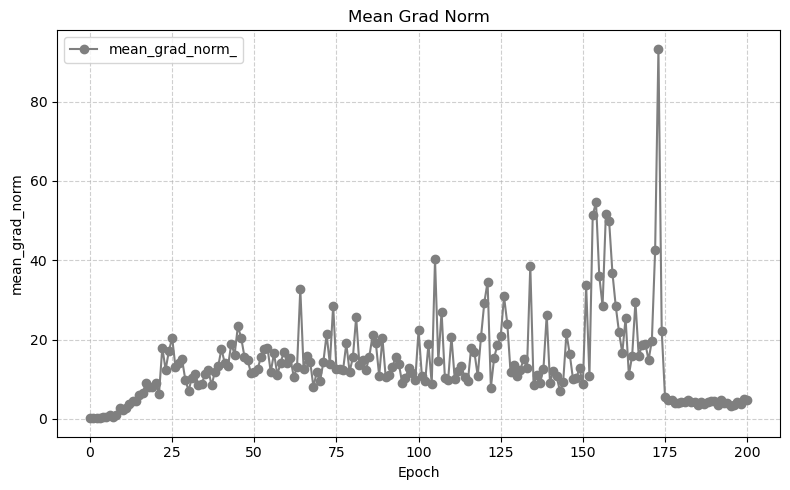

In [8]:
visualize_epoch_metrics(
 save_dir_path,
["val_prediction_loss_", "val_variance_loss_high_energy"
, "val_prediction_loss_high_energy", "val_variance_loss_training_set", "val_prediction_loss_training_set",  "val_variance_loss_", "train_total_loss_", "train_repulsion_loss_", "train_hsic_loss_" , "validation_criterio", "mean_grad_norm_"],
plot_on_same_graph=True,
verbose=True,
specific_epochs=[0, 200]
)




📊 Processing directory: val_trajectories_data

For the epoch_738 in val_trajectories_data the values are:
5: X_mean = 0.8274 ± 0.0769, U_mean = 0.7599 ± 0.0845 and energy=1.3666666666666667, phi0=0.7112530348369385
53: X_mean = 1.7731 ± 0.0570, U_mean = -1.9977 ± 0.0722 and energy=2.006666666666667, phi0=-2.4981901653384453
31: X_mean = 0.2768 ± 0.0647, U_mean = 0.2960 ± 0.0723 and energy=1.7133333333333338, phi0=0.2441816641299383

📊 Processing directory: val_train_set_trajectories_data

For the epoch_738 in val_train_set_trajectories_data the values are:
61: X_mean = 0.2667 ± 0.0422, U_mean = 0.5972 ± 0.0322 and energy=2.1133333333333333, phi0=0.5187756048832214
54: X_mean = 1.4465 ± 0.0663, U_mean = -2.1620 ± 0.0612 and energy=2.02, phi0=-2.234453591452867
16: X_mean = 0.2997 ± 0.0380, U_mean = -1.3620 ± 0.0682 and energy=1.5133333333333334, phi0=-1.1130378924250106

📊 Processing directory: val_high_energy_trajectories_data

For the epoch_738 in val_high_energy_trajectories_data th

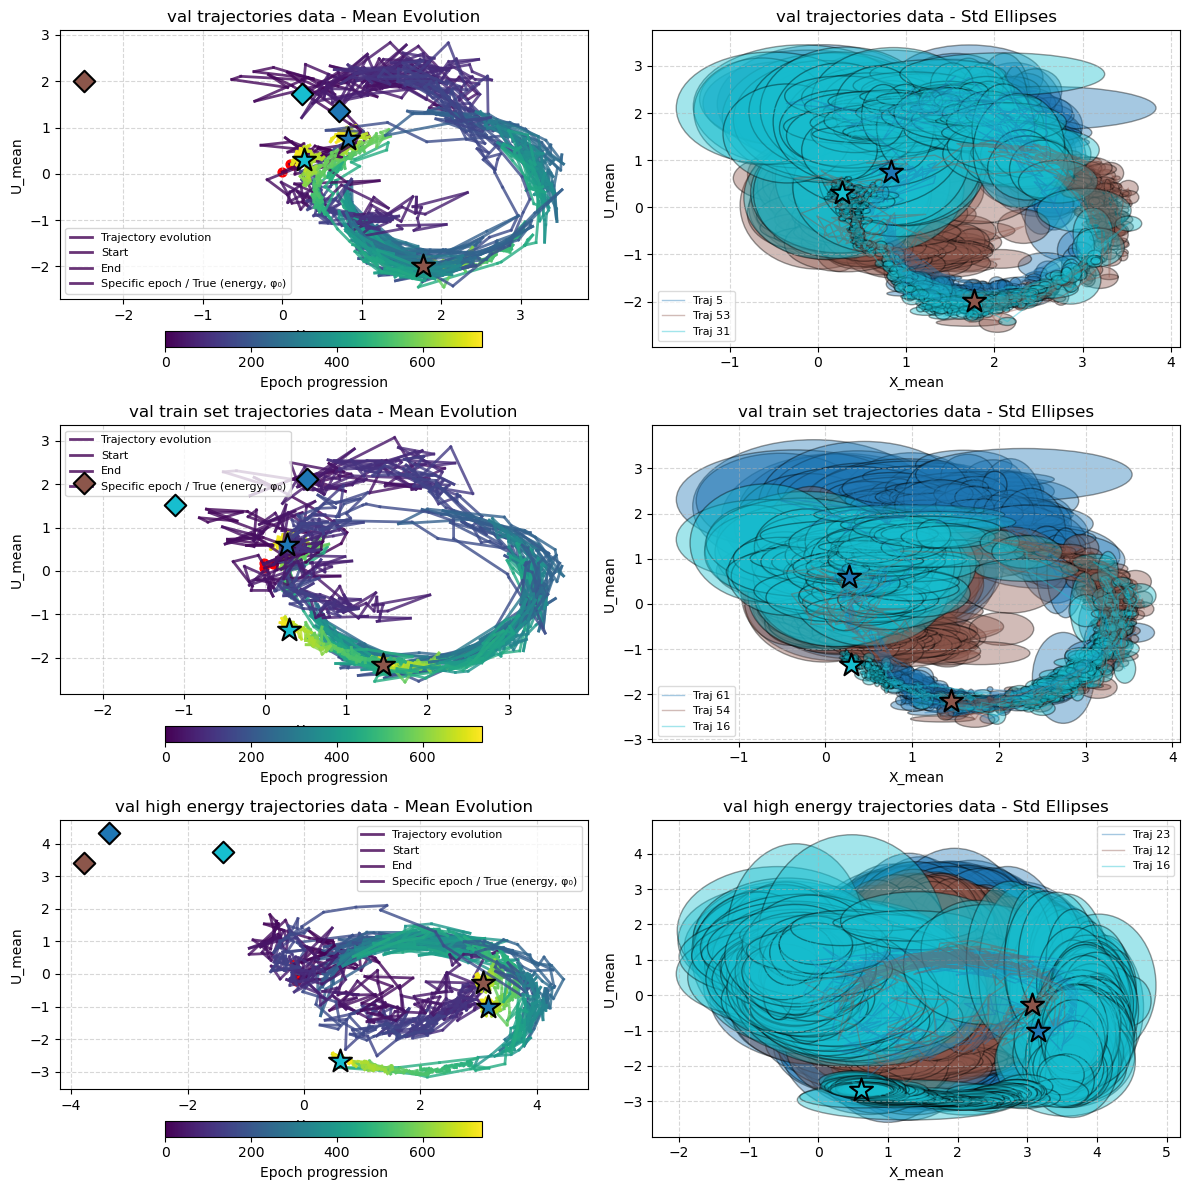


✅ Mean + Std (ellipse) visualization complete.


In [112]:
visualize_trajectory_movements_with_std_ellipses(save_dir_path, number_of_points_to_plot=3, right_plot_alpha=0.4, verbose=True, specific_epoch = "last", visualize_true_constants=True,train_id_df_added=train_id_df_low_samples_pendulum,val_id_df_added=val_id_df_low_samples_pendulum,val_id_df_high_energy_added=val_id_df_high_energy_low_samples_pendulum, pendulum=True)

In [207]:
val_differencies_df, val_train_differencies_set_df, val_high_energy_differencies_df = analyze_means_with_constants(
    save_dir_path=save_dir_path,
    specific_epoch="last",
    train_id_df_added=train_id_df_low_samples_pendulum,
    val_id_df_added=val_id_df_low_samples_pendulum,
    val_id_df_high_energy_added=val_id_df_high_energy_low_samples_pendulum,
    pendulum=True
)

📂 Using data from epoch: epoch_621
✅ Data extraction complete.


In [208]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['energy']),
    y=torch.Tensor(val_train_differencies_set_df['phi0']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.)

In [209]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['X_mean']),
    y=torch.Tensor(val_train_differencies_set_df['U_mean']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.0051)

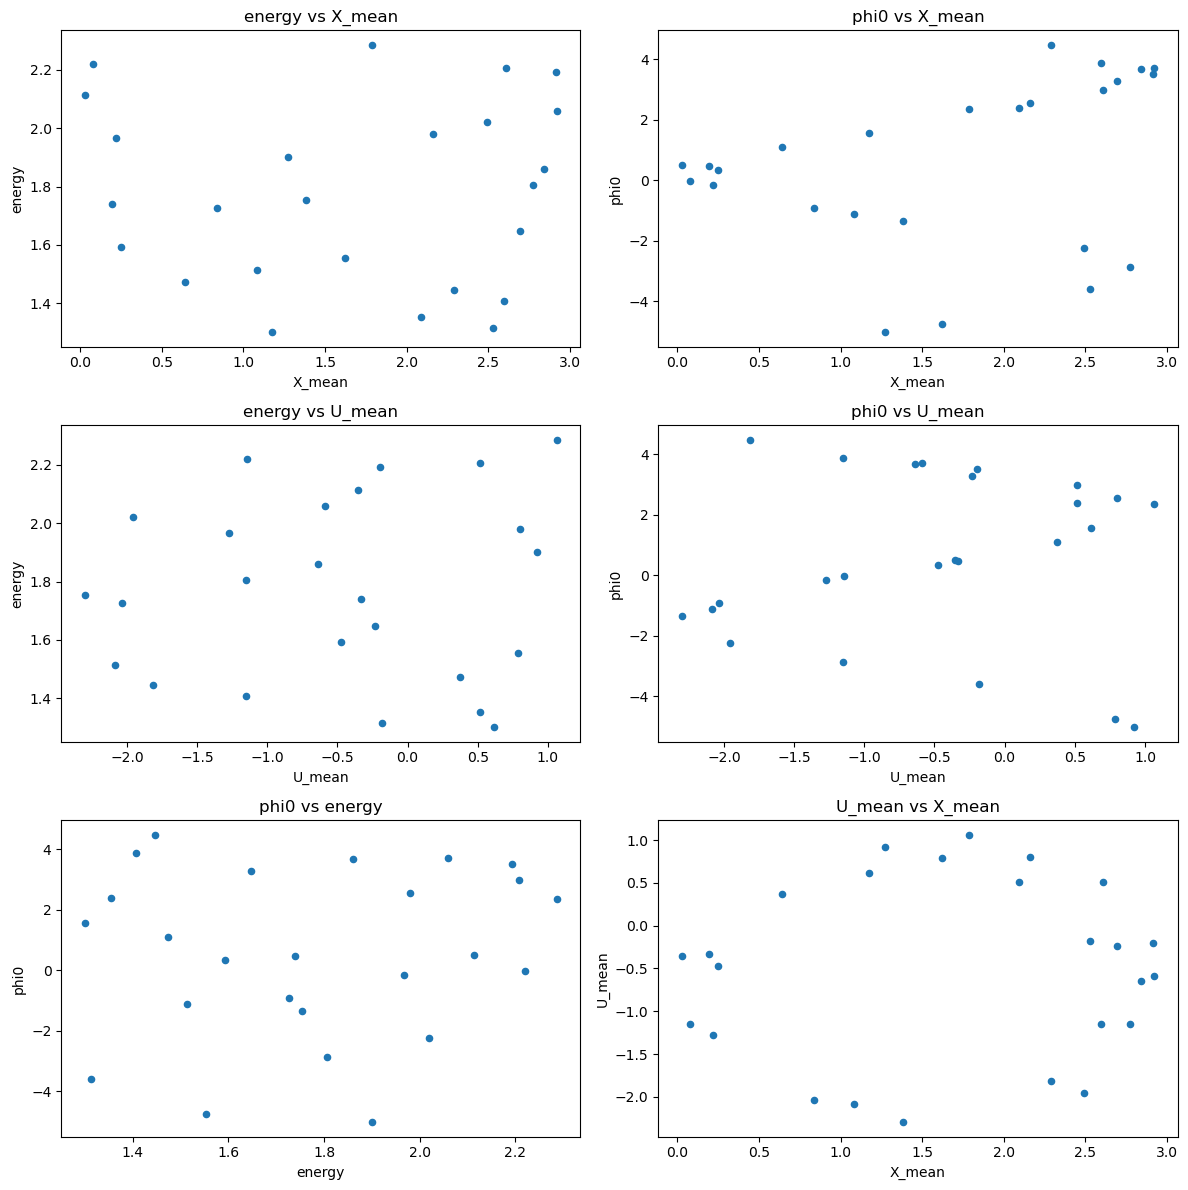

In [210]:
plot_differencies(val_train_differencies_set_df, pendulum=True)

📊 Analyzing 708 epochs across 3 directories...

📁 Processing directory: val_trajectories_data

📁 Processing directory: val_train_set_trajectories_data

📁 Processing directory: val_high_energy_trajectories_data


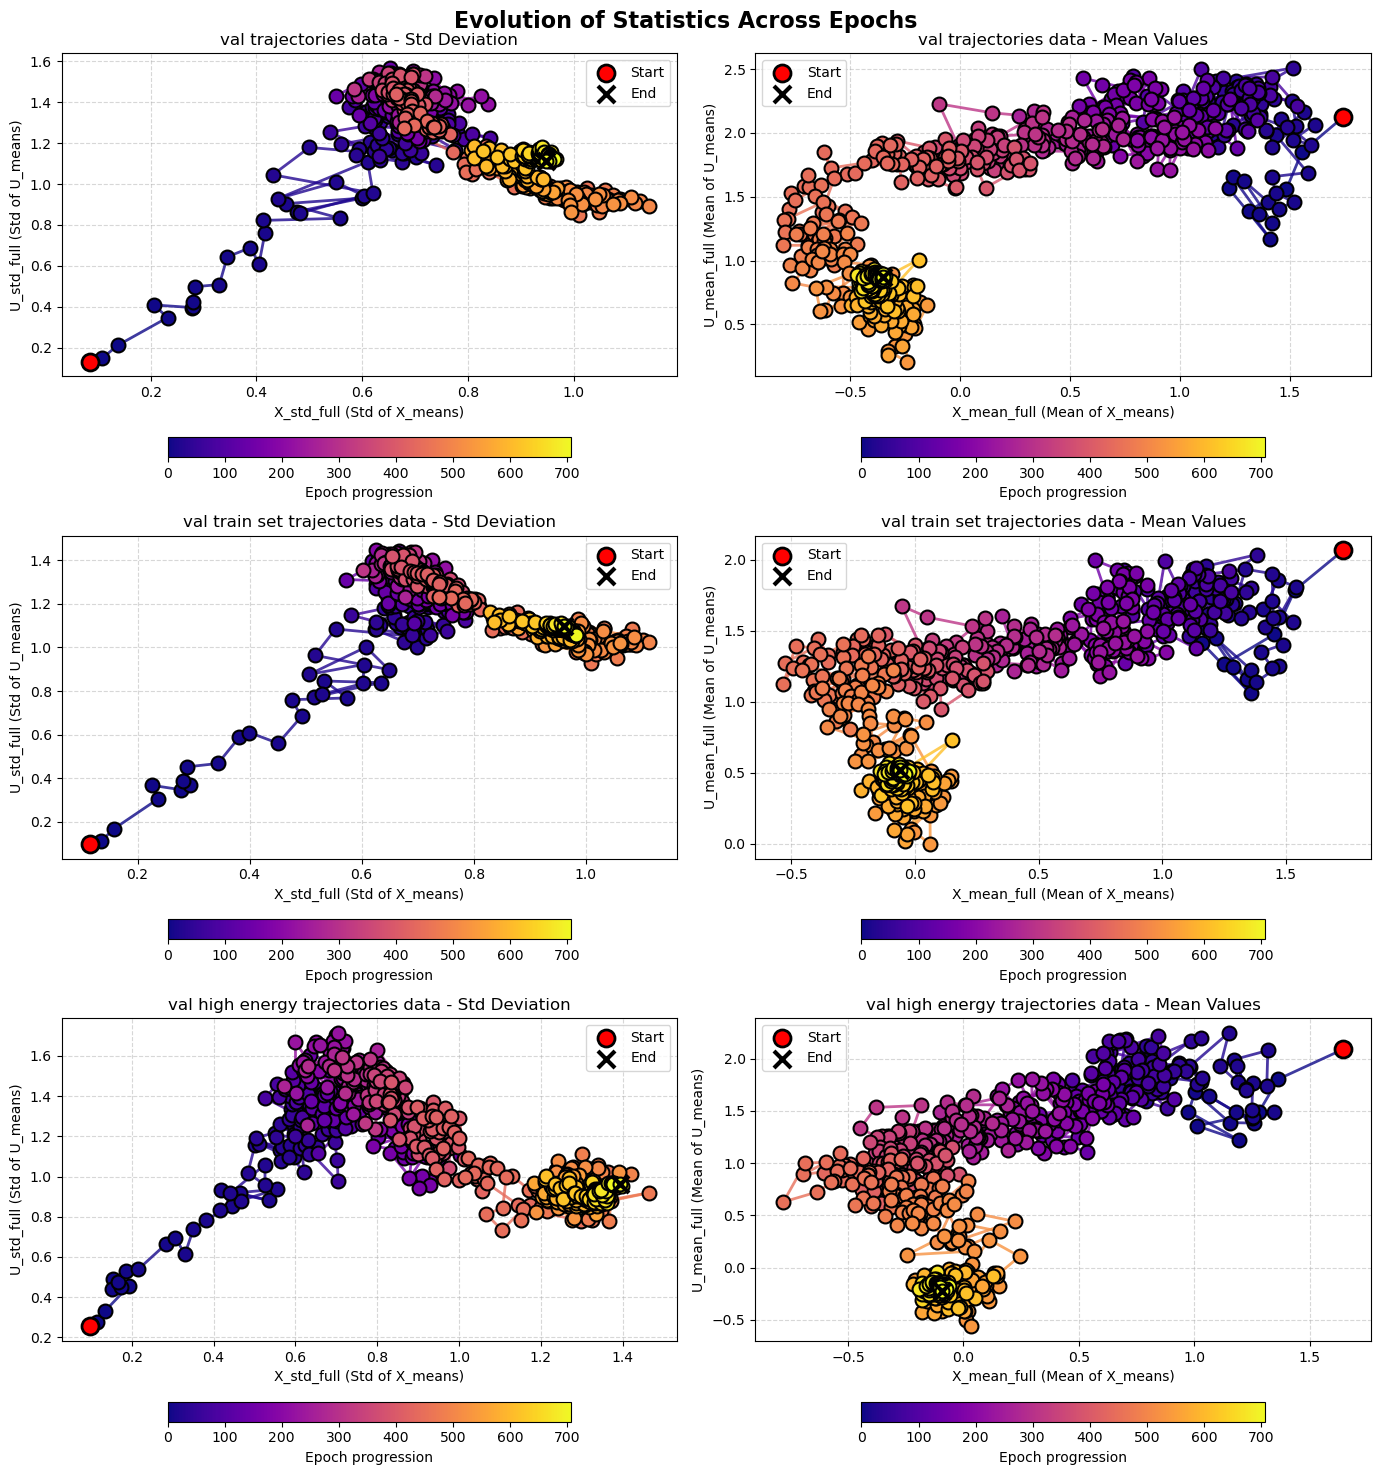

In [107]:
analyze_folders_means(save_dir_path, locate_epoch=None)

In [7]:
device = "cuda"
mapping_net = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
    n_layers=10,
        # MLP Architecture parameters
    hidden_dims= [33, 60, 32],
    n_hidden_layers = None,   #Leave None if you provide list on hidden_dims
        
        # Activation parameters
    activation = 'gelu',
    activation_params = None,
    final_activation = None,   #Final layer activation function
    #final_activation_only_on_final_layer = True,
    tanh_wrapper = False,
        
        # Initialization parameters
    weight_init = 'orthogonal',
    weight_init_params = {'gain': 1},
    bias_init = 'zeros',
    bias_init_value = 0.0,
        
        
        # Architectural choices
    use_bias = True,
    use_layer_norm = False,
    
    # Input/Output parameters
    input_dim = 2,  # x or u and t
    output_dim = 1,  # scalar G or F
    a_eps_min= 0.5,  # Minimum value for a
    a_eps_max= 2,  # Maximum value for a  
    a_k= 0.1,

    step_1_a_mean_innit= 1.2,
    step_2_a_mean_innit= 1.2,
    std_to_mean_ratio_a_mean_init= 0.0,

    step_1_gamma_mean_innit= 0.5,
    step_2_gamma_mean_innit= 0.5,
    std_to_mean_ratio_gamma_mean_init= 0.0,

    step_1_c1_mean_innit= 0.0,
    step_2_c1_mean_innit= 0.0,
    std_to_mean_ratio_c1_mean_init= 1.0,

    step_1_c2_mean_innit= 0.0,
    step_2_c2_mean_innit= 0.0,
    std_to_mean_ratio_c2_mean_init= 1.0,

    bound_innit=0.0,
).to(device)

checkpoint_path = os.path.join(save_dir_path, "best_model.pt")

load_checkpoint(path=checkpoint_path, mapping_net=mapping_net, device=device, optimizer=None, scheduler=None)

inverse_net = InverseStackedHamiltonianNetwork(forward_network=mapping_net)


Successfully loaded model
Created inverse network with 10 reverse layers


/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:5601: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=devic

In [225]:
test_canonical_tranformation_on_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, compute_jacobian_functional_function=compute_jacobian_functional, compute_symplectic_product_function=compute_symplectic_product, check_canonical_transformation_function=check_canonical_transformation, tolerance=1e-4, test_id_df=val_id_df_low_samples_pendulum, test_df=val_df_low_samples_pendulum, trajectory_id=20, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

For the mapping network:
✓ All 30 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 5.36e-07
For the inverse network:
✓ All 30 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 3.58e-07


In [226]:
print(f"Number of parameters are: {count_parameters(mapping_net)}, with number of training samples: {train_df_low_samples_pendulum.shape[0]}\nThat is a ratio of parameters/samples of: {count_parameters(mapping_net)/train_df_low_samples_pendulum.shape[0]}")

Number of parameters are: 82560, with number of training samples: 750
That is a ratio of parameters/samples of: 110.08


   num_observed_points  mean_loss
0                    1   0.055836
1                    2   0.054704
2                    3   0.054358
3                    4   0.055789
4                    5   0.055101
5                    6   0.053949
6                    7   0.052154
7                    8   0.051576
8                    9   0.044093
9                   10   0.038831


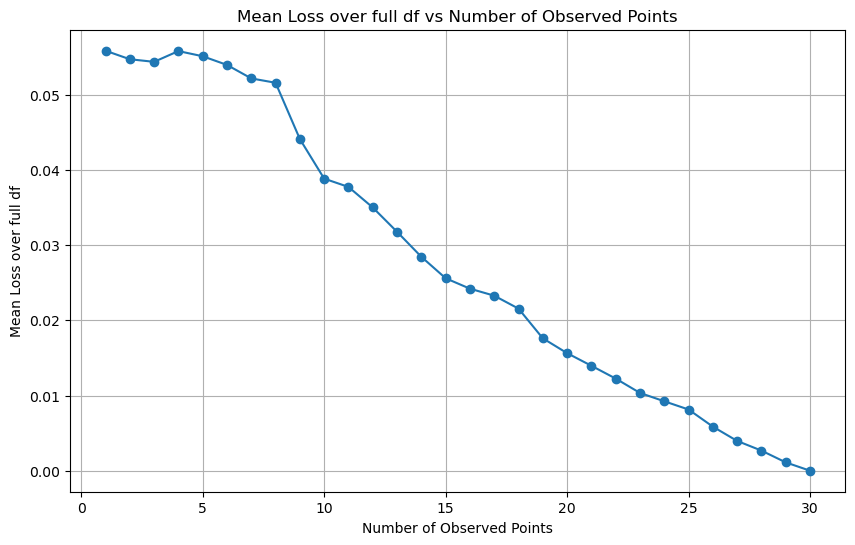

In [227]:
val_loss_per_points_df = test_model_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples_pendulum, test_df=val_df_low_samples_pendulum, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

   num_observed_points  mean_variance
0                    1       0.000000
1                    2       0.002637
2                    3       0.002376
3                    4       0.001827
4                    5       0.001771
5                    6       0.001786
6                    7       0.003341
7                    8       0.002975
8                    9       0.003011
9                   10       0.003118


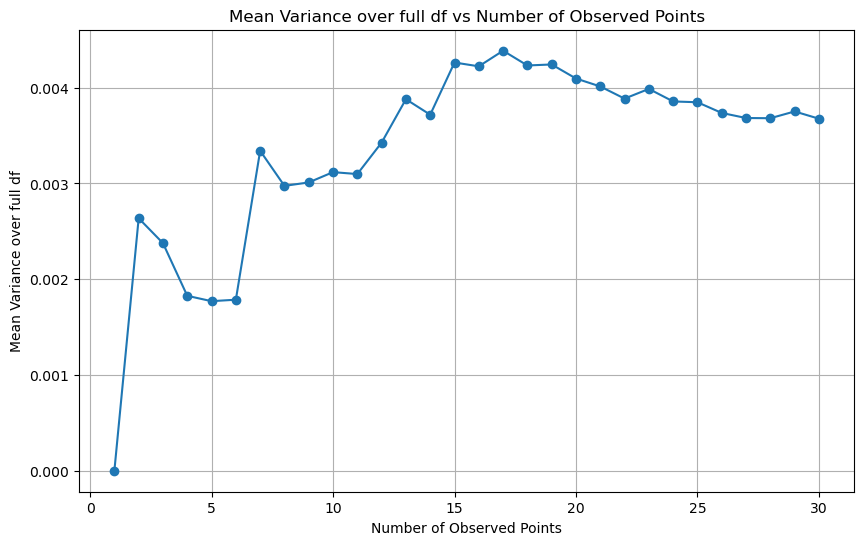

In [228]:
val_variance_per_points_df = test_model_variance_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id ,test_id_df=val_id_df_low_samples_pendulum, test_df=val_df_low_samples_pendulum, mapping_net=mapping_net ,device=device)

In [8]:
point_indexes_observed = [0]

In [9]:
tmax_list = []
for idx, row in train_id_df_low_samples_pendulum.iterrows():

    trajectory_id = int(row['trajectory_id'])
    start_index = int(row['start_index'])
    end_index = int(row['end_index'])
    
    test_trajectory_data = get_data_from_trajectory_id(train_id_df_low_samples_pendulum, train_df_low_samples_pendulum, trajectory_ids=trajectory_id)
    t = test_trajectory_data['t'].to_numpy(dtype=np.float32)
    tmax = max(t)
    tmax_list.append(tmax)
max_t_training = min(np.array(tmax_list))
dt = t[1] - t[0]

In [17]:
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ---------------------------------------------------------
# 1. PREPARE FIXED ARGUMENTS
# ---------------------------------------------------------
# These arguments never change during the optimization.
# We pack them here to keep the objective function clean.
fixed_args = {
    "get_data_from_trajectory_id_function": get_data_from_trajectory_id,
    "prediction_loss_function": prediction_loss_euclidean,
    "test_id_df": val_id_df_low_samples_pendulum,
    "test_df": val_df_low_samples_pendulum,
    "mapping_net": mapping_net,
    "inverse_net": inverse_net,
    "device": device,
    "point_indexes_observed": point_indexes_observed,
    "recreate_and_plot_phase_space": False,
    "plot_specific_portion": 0.26,
    "connect_points": False,
    "plot_trajectories_subsample": 0.4,
    "max_t_training": max_t_training,
    "efficiently": False,
    "method": "gaussian_mixture_simple",
    "threshold": 1.0,
    "dt": dt,
    "alpha":1.0,
    "gamma":1.0,
    "cluster_weight_threshold": 0.4,
    "search_range_lower_pct": 0.1,  # Assuming this is fixed
    "verbose":False
}

# ---------------------------------------------------------
# 2. DEFINE THE OBJECTIVE FUNCTION
# ---------------------------------------------------------
def objective(trial):
    """
    This function runs ONE experiment. 
    Optuna provides the 'trial' object which we use to select params.
    """
    

    # B. Conditional Logic (The Bayesian part)
    # Optuna's sampler will learn that 'threshold' is only relevant when efficiently=False

        
    # suggest_float(name, low, high)

    search_range_upper_pct_param = trial.suggest_float("search_range_upper_pct", 0.3, 0.7) 
    max_n_components_param = trial.suggest_int("max_n_components", 2, 5)

    # C. Run your actual function
    # We handle exceptions so one bad run doesn't crash the whole study
    try:
        _, mean_loss = test_model_in_all_trajectories_in_df(
            search_range_upper_pct = search_range_upper_pct_param,
            max_n_components = max_n_components_param,
            **fixed_args
        )
    except Exception as e:
        print(f"Trial failed: {e}")
        # Return infinity so Optuna knows this was a terrible run
        return float('inf')

    # D. Return the value we want to MINIMIZE
    return mean_loss

# ---------------------------------------------------------
# 3. RUN THE OPTIMIZATION (THE STUDY)
# ---------------------------------------------------------
print("Starting Bayesian Optimization...")

# Create the study. We want to 'minimize' the loss.
study = optuna.create_study(direction="minimize")

# n_trials=20 means it will run your function 20 times. 
# Increase this to 50 or 100 if you have time.
study.optimize(objective, n_trials=30, show_progress_bar=True)

# ---------------------------------------------------------
# 4. VIEW RESULTS
# ---------------------------------------------------------
print("-" * 30)
print("BEST RESULTS FOUND:")
print(f"Best Mean Loss: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

# If you want to see all trials as a DataFrame:
df_results = study.trials_dataframe()
# print(df_results)

Starting Bayesian Optimization...


Best trial: 27. Best value: 0.0706687: 100%|██████████| 30/30 [3:01:40<00:00, 363.35s/it] 

------------------------------
BEST RESULTS FOUND:
Best Mean Loss: 0.0706686808168888
Best Hyperparameters: {'search_range_upper_pct': 0.6092434547598503, 'max_n_components': 3}


    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
3               3  1.340000         0.097233              0.083997
5               5  1.366667         0.080267              0.068661
7               7  1.393333         0.087217              0.073888
10             10  1.433333         0.080310              0.067080
14             14  1.486667         0.099487              0.081594
18             18  1.540000         0.086174              0.069441
20             20  1.566667         0.111257              0.088887
21             21  1.580000         0.096348              0.076651
23             23  1.606667         0.082642              0.065198
27             27  1.660000         0.043127              0.033473
31             31  1.713333         0.118475              0.090512
35             35  1.766667         0.067932              0.051109
37             37  1.793333         0.087974              0.065694
44             44  1.886667         0.096435              0.07

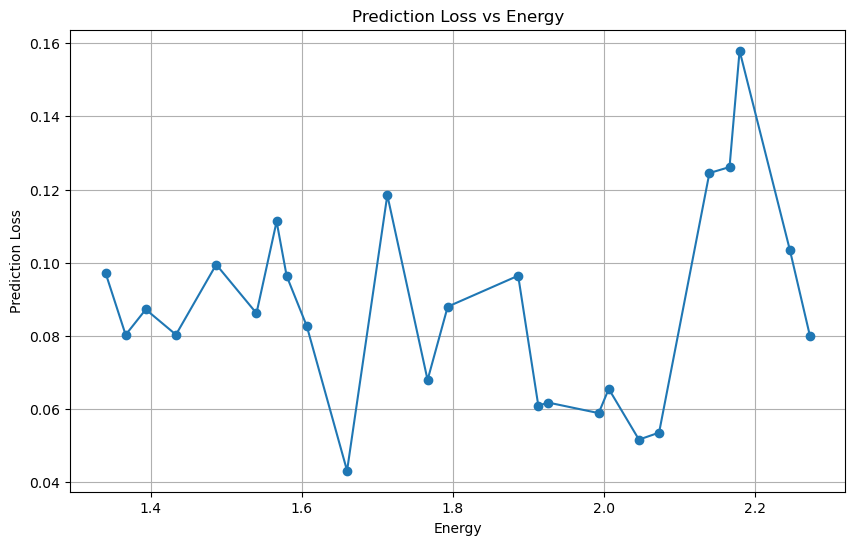

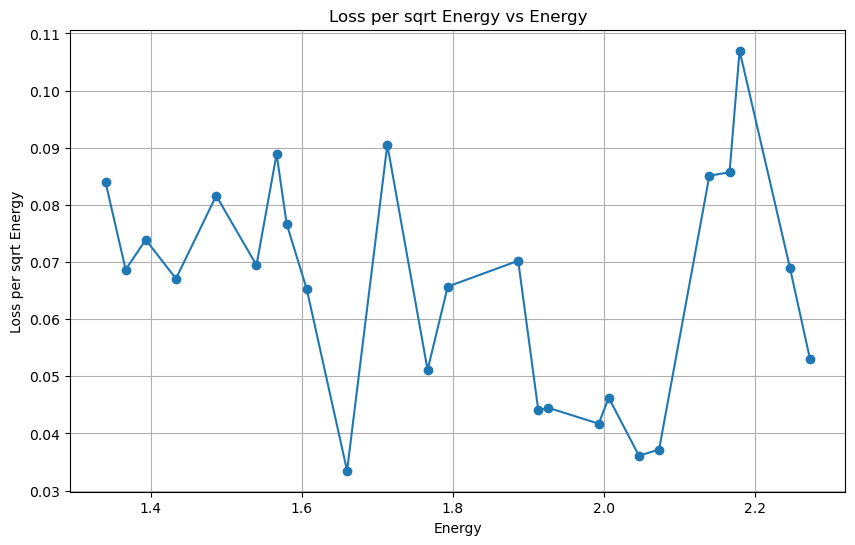

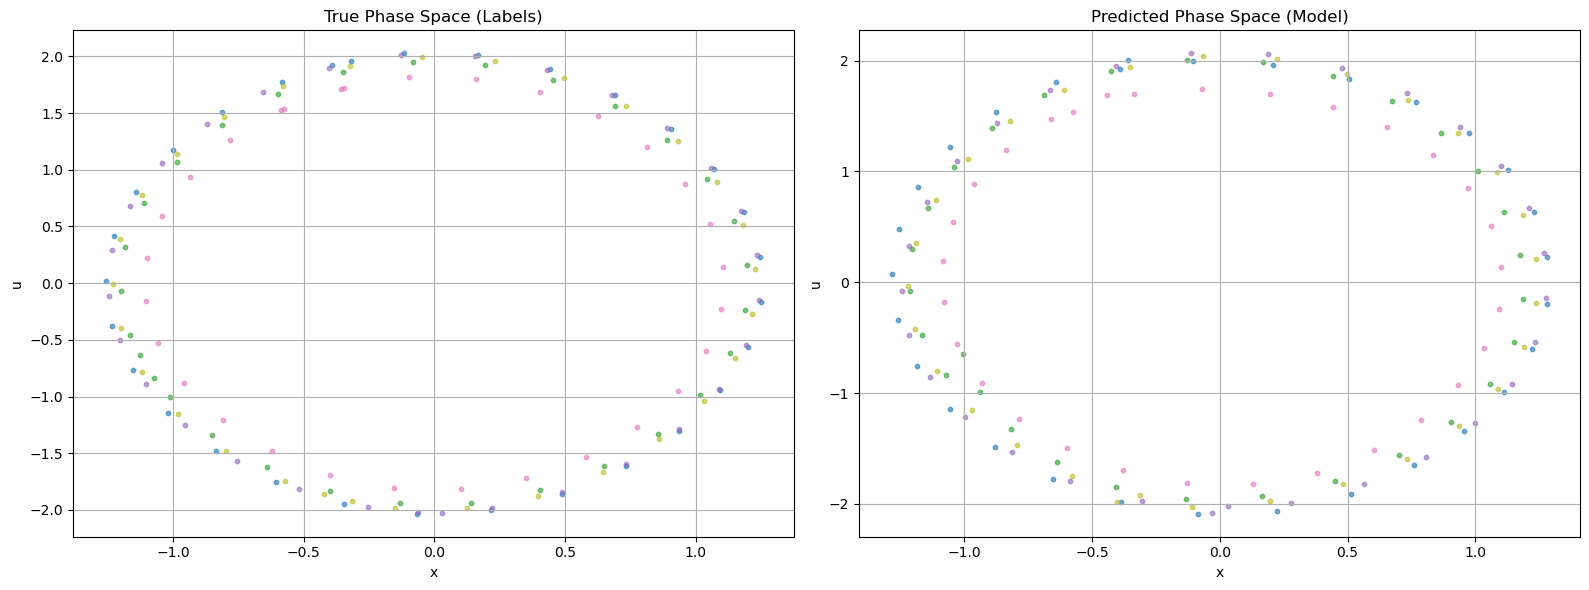

In [ ]:
prediction_val_df, mean_prediction_loss_val, pred_val_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples_pendulum, test_df=val_df_low_samples_pendulum, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
3               3  1.340000         0.099552              0.086000
5               5  1.366667         0.117889              0.100842
7               7  1.393333         0.090847              0.076963
10             10  1.433333         0.087336              0.072949
14             14  1.486667         0.090648              0.074345
18             18  1.540000         0.070121              0.056505
20             20  1.566667         0.070710              0.056492
21             21  1.580000         0.085193              0.067776
23             23  1.606667         0.069647              0.054946
27             27  1.660000         0.054771              0.042511
31             31  1.713333         0.078863              0.060250
35             35  1.766667         0.058307              0.043867
37             37  1.793333         0.058944              0.044016
44             44  1.886667         0.050822              0.03

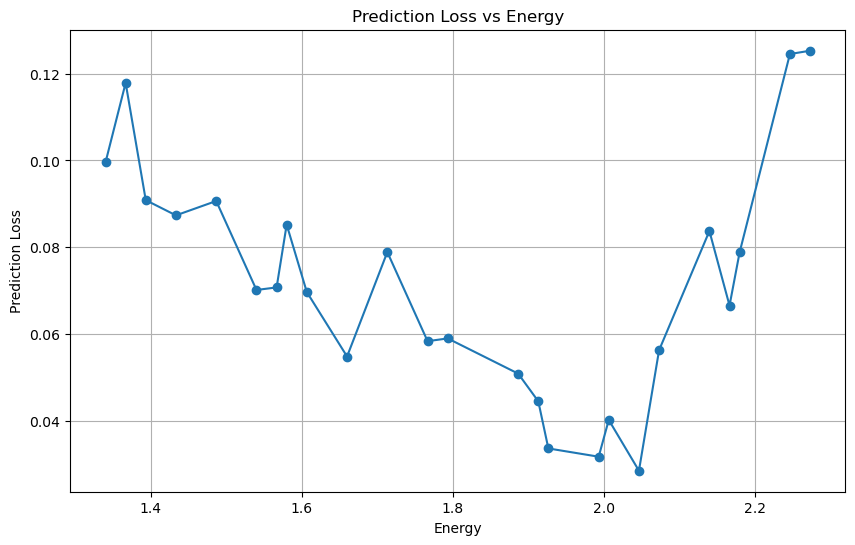

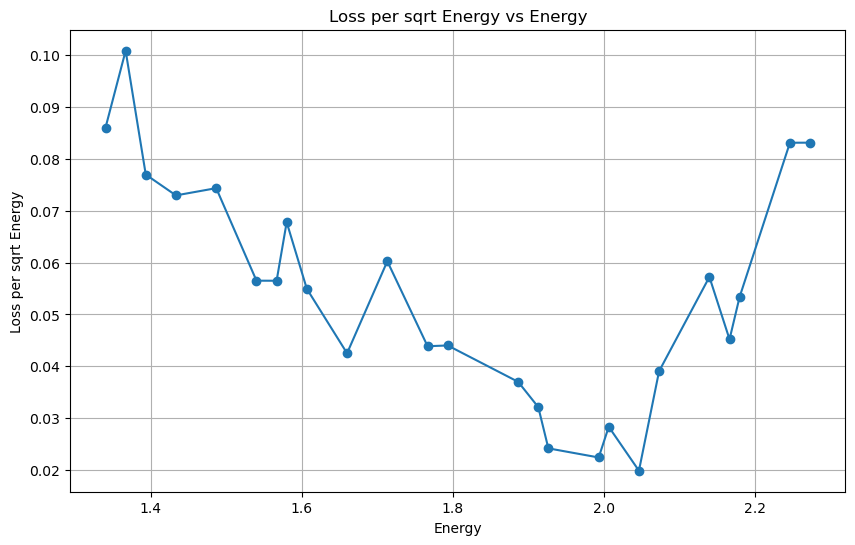

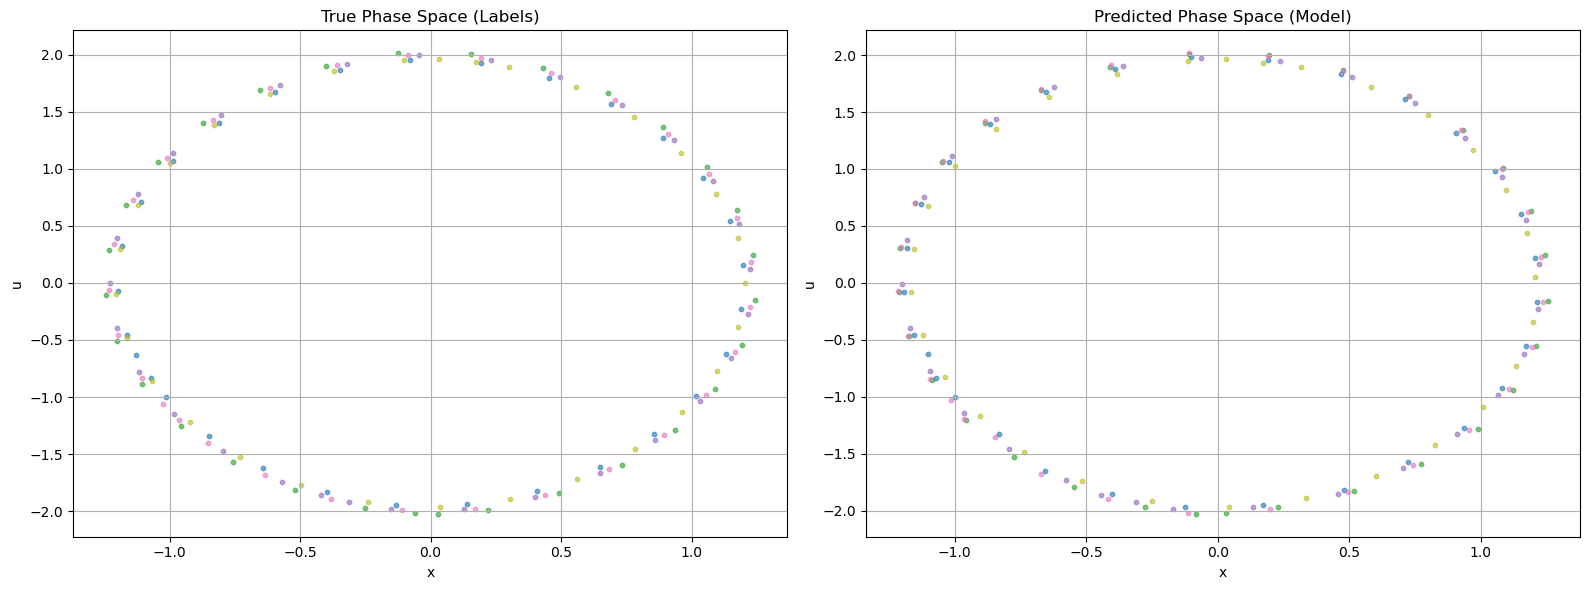

In [ ]:
prediction_val_ensemble_df, mean_prediction_loss_val_ensemble, pred_val_ensemble_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples_pendulum, test_df=val_df_low_samples_pendulum, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=False, efficiently=False, method="gaussian_mixture_simple", threshold=0.5556654999491227, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=3, search_range_lower_pct=0.1, search_range_upper_pct=0.6092434547598503, verbose=True)

    trajectory_id    energy  variance_loss  variance_per_sqrt_energy
3               3  1.340000            0.0                       0.0
5               5  1.366667            0.0                       0.0
7               7  1.393333            0.0                       0.0
10             10  1.433333            0.0                       0.0
14             14  1.486667            0.0                       0.0
18             18  1.540000            0.0                       0.0
20             20  1.566667            0.0                       0.0
21             21  1.580000            0.0                       0.0
23             23  1.606667            0.0                       0.0
27             27  1.660000            0.0                       0.0
31             31  1.713333            0.0                       0.0
35             35  1.766667            0.0                       0.0
37             37  1.793333            0.0                       0.0
44             44  1.886667       

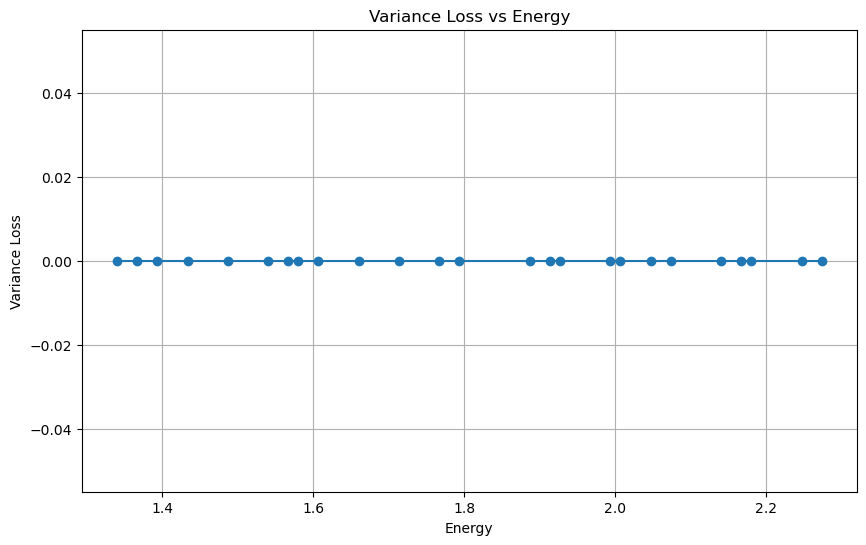

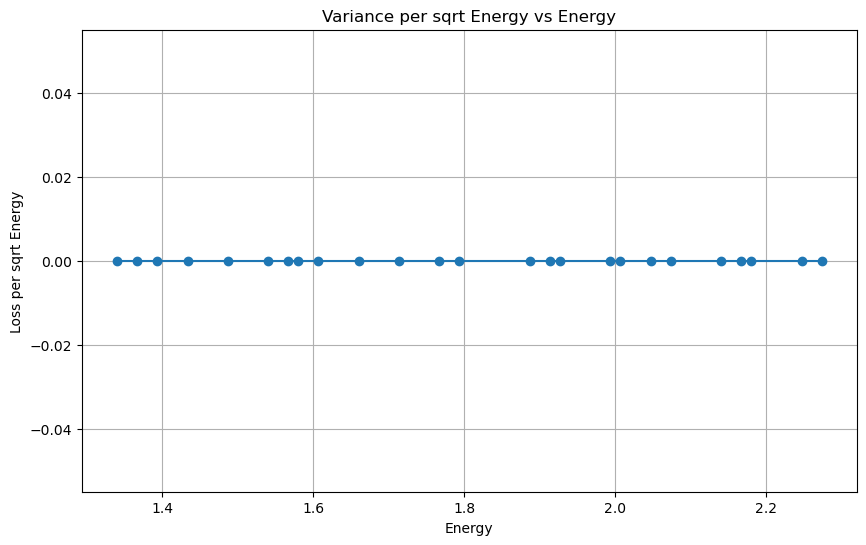

In [231]:
variance_val_df, mean_variance_loss_val = test_model_variance_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, test_id_df=val_id_df_low_samples_pendulum, test_df=val_df_low_samples_pendulum, mapping_net=mapping_net, device=device, point_indexes_observed=point_indexes_observed)


In [13]:
trajectory_id_to_show_val=56
period_val = val_id_df_low_samples_pendulum[val_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_val]['period'].values[0] if val_id_df_low_samples_pendulum[val_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_val]['motion_type'].values[0] == "oscillating" else 0.0

trajectory_id_to_show_val_ensemble = 56
period_val_ensemble = val_id_df_low_samples_pendulum[val_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_val_ensemble]['period'].values[0] if val_id_df_low_samples_pendulum[val_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_val_ensemble]['motion_type'].values[0] == "oscillating" else 0.0


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 1
inverse_net calls: 1
Total forward passes: 2
Observed time points: [0.]


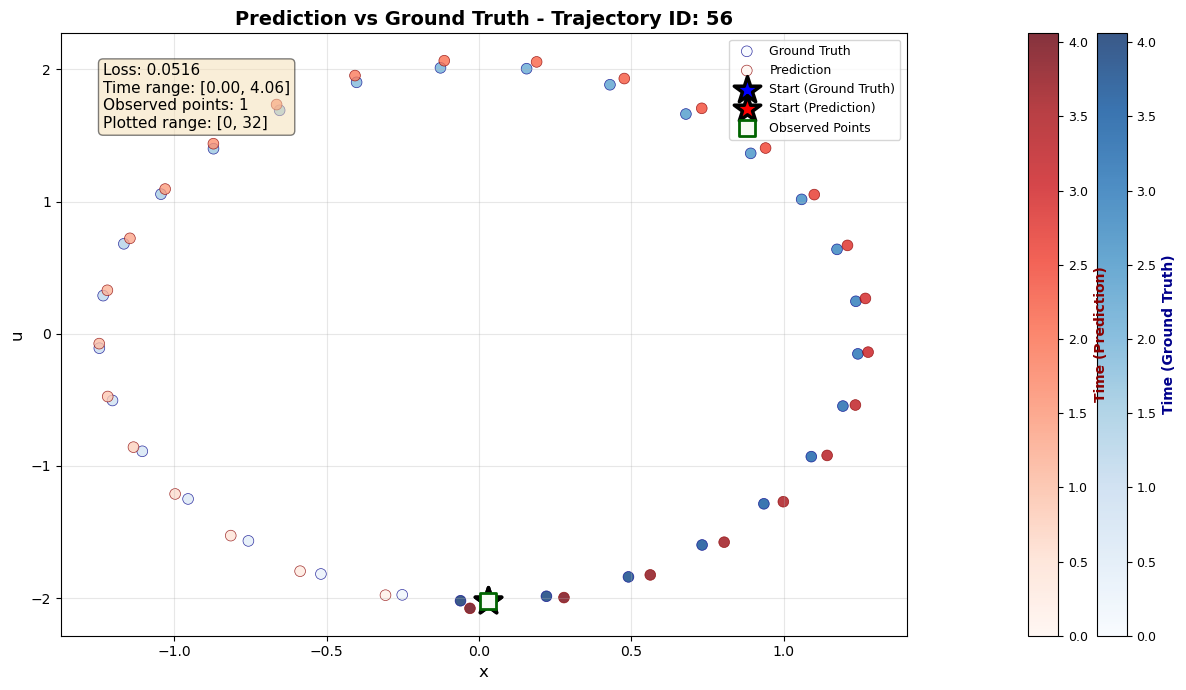

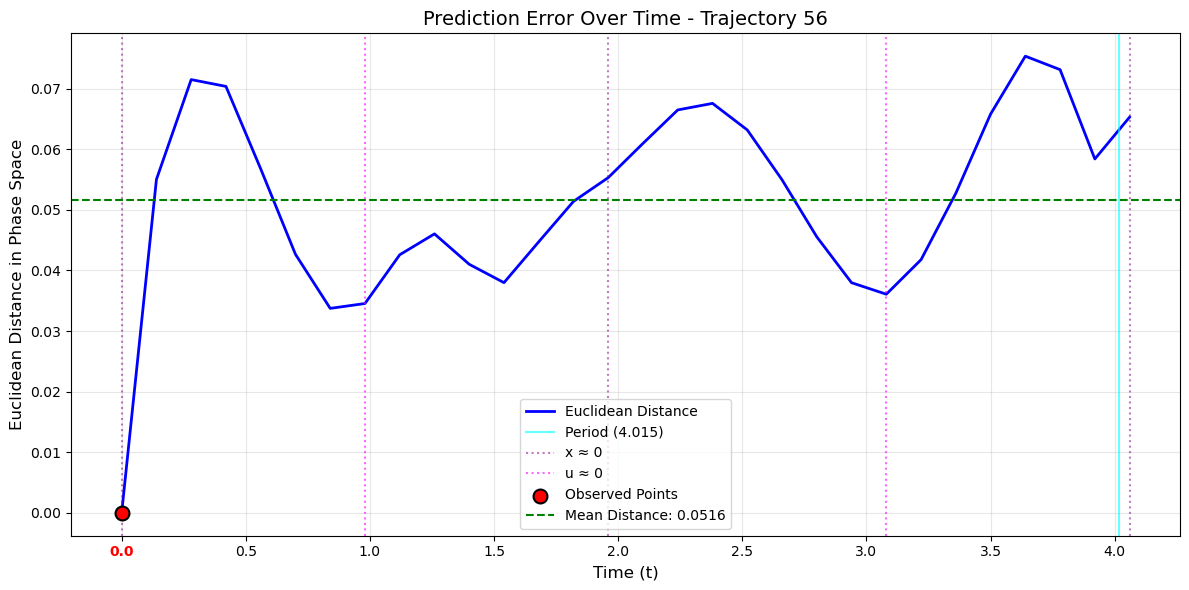

In [14]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples_pendulum, test_df=val_df_low_samples_pendulum, trajectory_id=trajectory_id_to_show_val, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period_val, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 3
inverse_net calls: 89
Total forward passes: 92
Coverage: 100.0%
Observed time points: [0.]


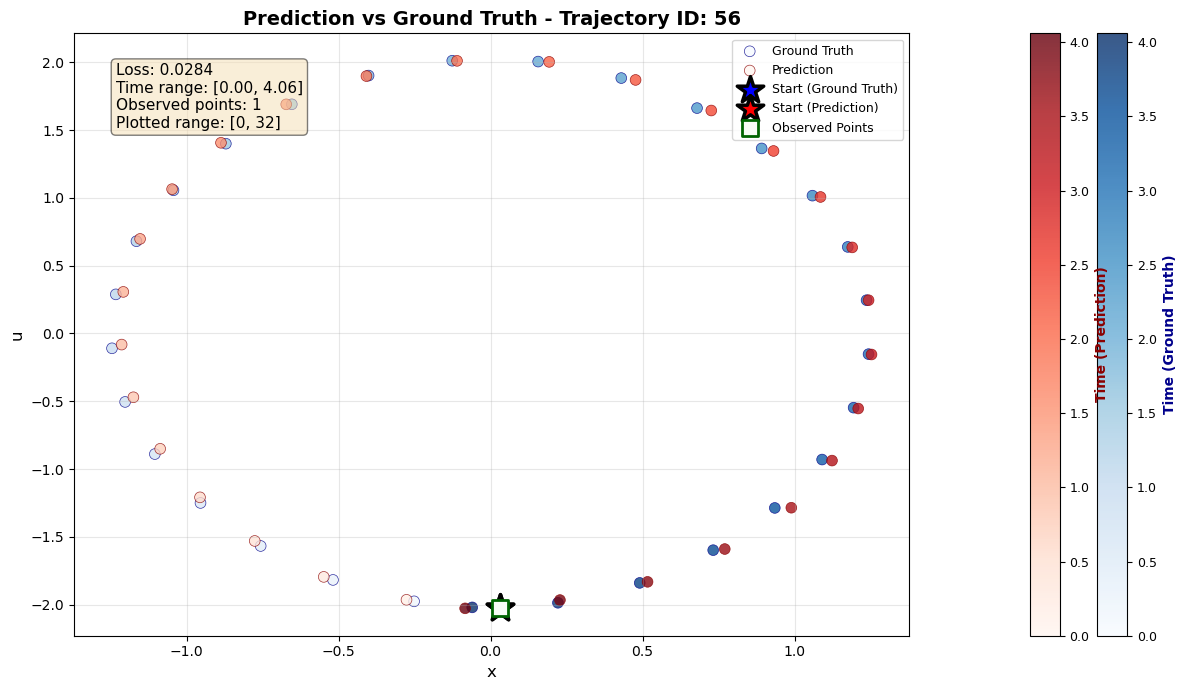

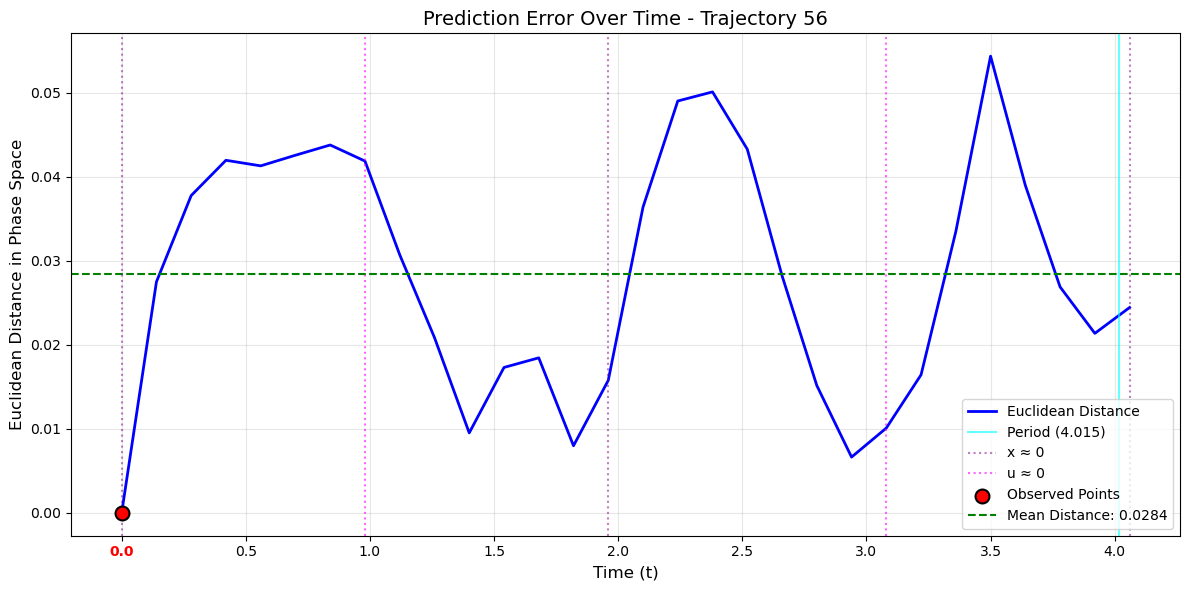

In [ ]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples_pendulum, test_df=val_df_low_samples_pendulum, trajectory_id=trajectory_id_to_show_val_ensemble, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period_val_ensemble, max_t_training=max_t_training, efficiently=False, method="gaussian_mixture_simple", threshold=0.5556654999491227, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=3, search_range_lower_pct=0.1, search_range_upper_pct=0.6092434547598503, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
2               2  1.326667         0.131035              0.113764
6               6  1.380000         0.157210              0.133826
9               9  1.420000         0.072696              0.061005
12             12  1.460000         0.122933              0.101740
15             15  1.500000         0.091404              0.074631
17             17  1.526667         0.087320              0.070671
24             24  1.620000         0.096927              0.076153
25             25  1.633333         0.082336              0.064425
28             28  1.673333         0.124120              0.095951
29             29  1.686667         0.101465              0.078127
30             30  1.700000         0.060274              0.046228
36             36  1.780000         0.067002              0.050220
39             39  1.820000         0.062441              0.046284
40             40  1.833333         0.074316              0.05

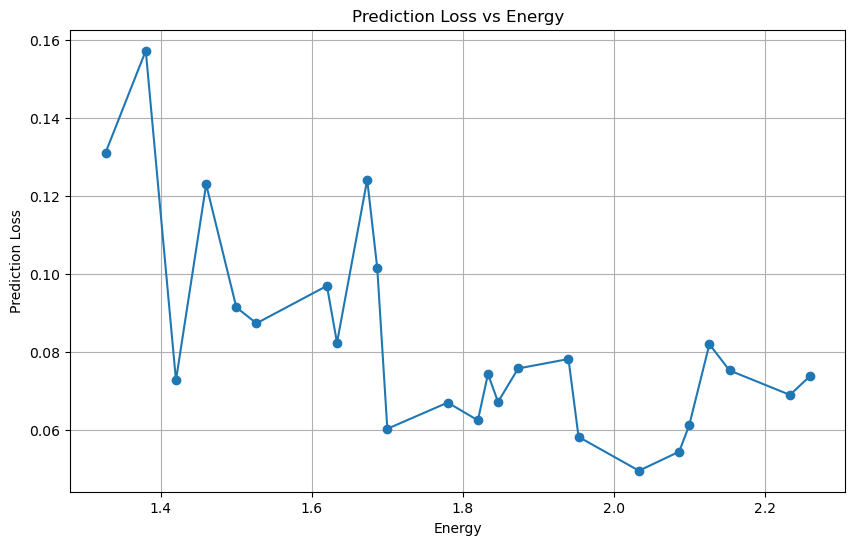

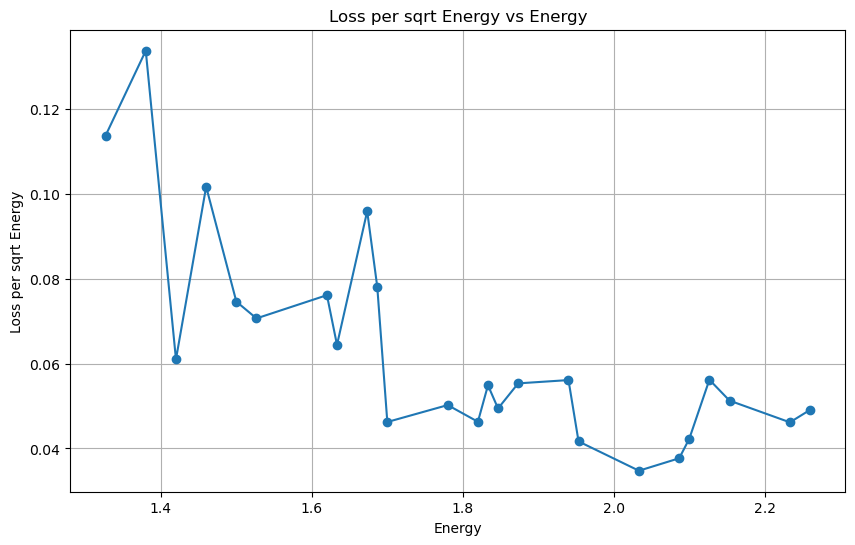

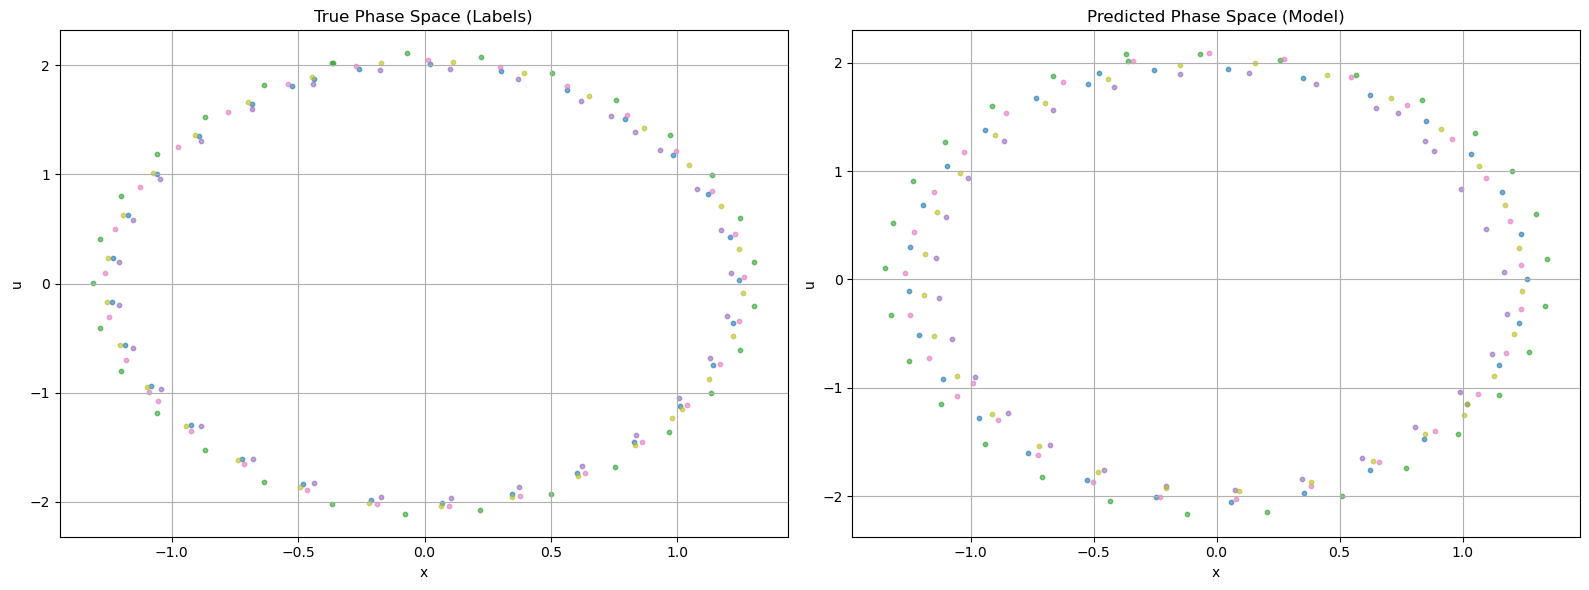

In [ ]:
prediction_test_df, mean_prediction_loss_test, pred_test_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples_pendulum, test_df=test_df_low_samples_pendulum, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
2               2  1.326667         0.119181              0.103472
6               6  1.380000         0.117786              0.100266
9               9  1.420000         0.101064              0.084811
12             12  1.460000         0.104375              0.086381
15             15  1.500000         0.080197              0.065481
17             17  1.526667         0.071702              0.058031
24             24  1.620000         0.103239              0.081112
25             25  1.633333         0.071766              0.056154
28             28  1.673333         0.090040              0.069606
29             29  1.686667         0.066166              0.050947
30             30  1.700000         0.046645              0.035775
36             36  1.780000         0.040033              0.030006
39             39  1.820000         0.046473              0.034448
40             40  1.833333         0.035423              0.02

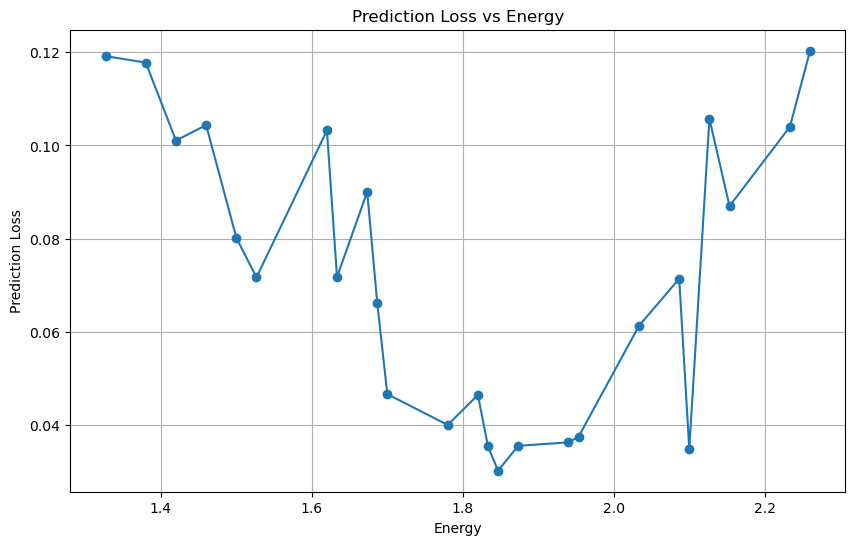

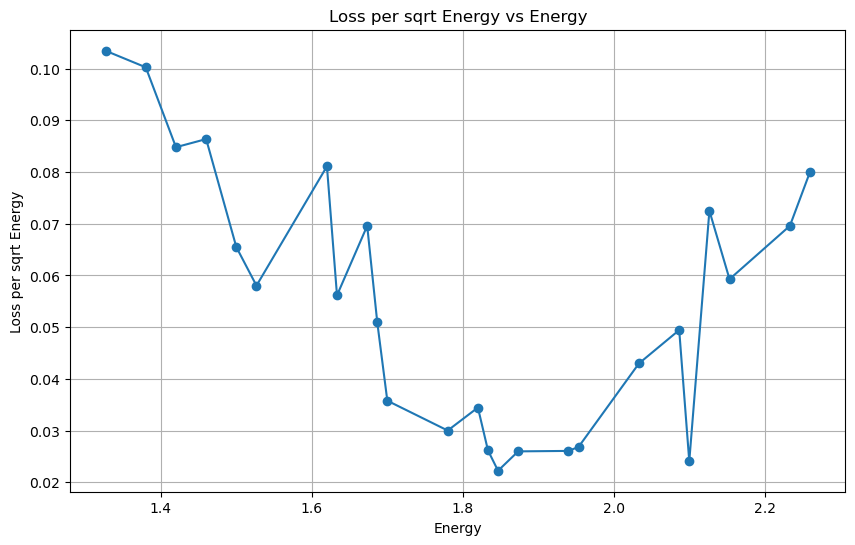

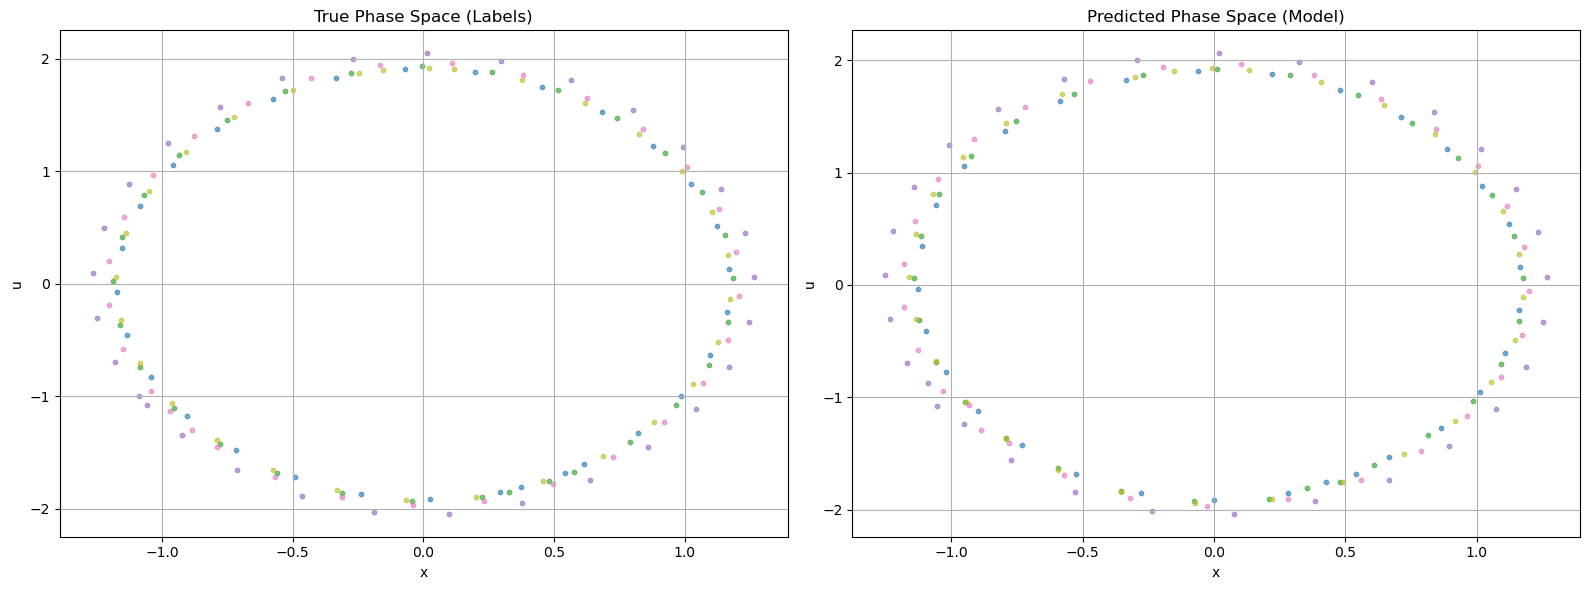

In [ ]:
prediction_test_ensemble_df, mean_prediction_loss_test_ensemble, pred_test_ensemble_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples_pendulum, test_df=test_df_low_samples_pendulum, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=False, method="gaussian_mixture_simple", threshold=0.5556654999491227, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=3, search_range_lower_pct=0.1, search_range_upper_pct=0.6092434547598503, verbose=True)

    trajectory_id    energy  variance_loss  variance_per_sqrt_energy
2               2  1.326667            0.0                       0.0
6               6  1.380000            0.0                       0.0
9               9  1.420000            0.0                       0.0
12             12  1.460000            0.0                       0.0
15             15  1.500000            0.0                       0.0
17             17  1.526667            0.0                       0.0
24             24  1.620000            0.0                       0.0
25             25  1.633333            0.0                       0.0
28             28  1.673333            0.0                       0.0
29             29  1.686667            0.0                       0.0
30             30  1.700000            0.0                       0.0
36             36  1.780000            0.0                       0.0
39             39  1.820000            0.0                       0.0
40             40  1.833333       

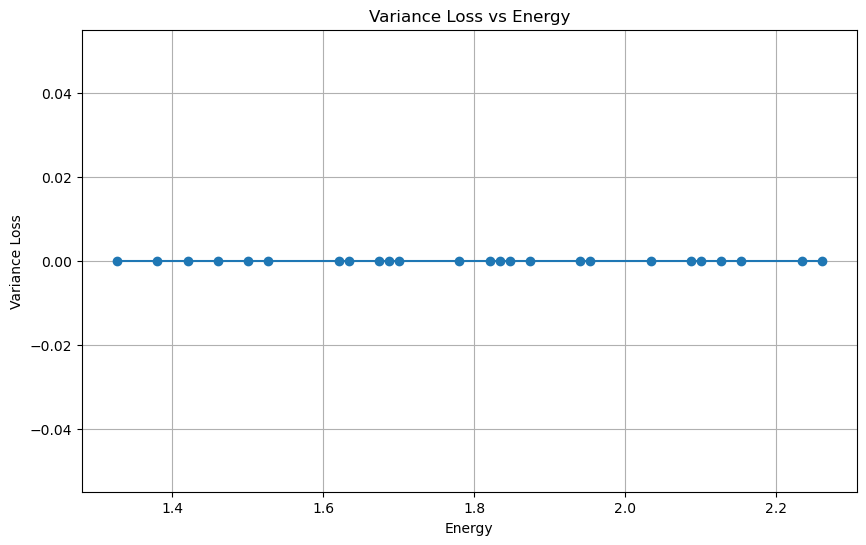

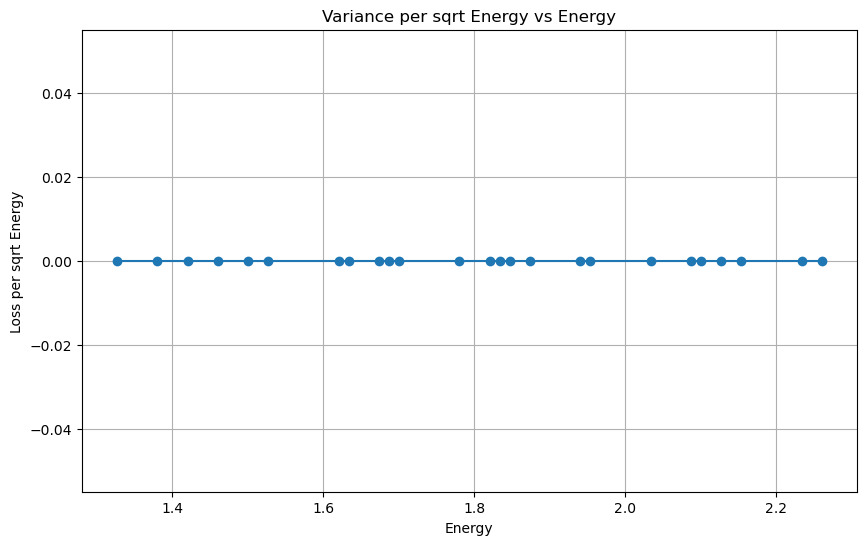

In [76]:
variance_test_df, mean_variance_loss_test = test_model_variance_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, test_id_df=test_id_df_low_samples_pendulum, test_df=test_df_low_samples_pendulum, mapping_net=mapping_net, device=device, point_indexes_observed=point_indexes_observed)


In [17]:
trajectory_id_to_show_test=55
period_test = test_id_df_low_samples_pendulum[test_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test]['period'].values[0] if test_id_df_low_samples_pendulum[test_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test]['motion_type'].values[0] == "oscillating" else 0.0

trajectory_id_to_show_test_ensemble=41
period_test_ensemble = test_id_df_low_samples_pendulum[test_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_ensemble]['period'].values[0] if test_id_df_low_samples_pendulum[test_id_df_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_ensemble]['motion_type'].values[0] == "oscillating" else 0.0


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 1
inverse_net calls: 1
Total forward passes: 2
Observed time points: [0.]


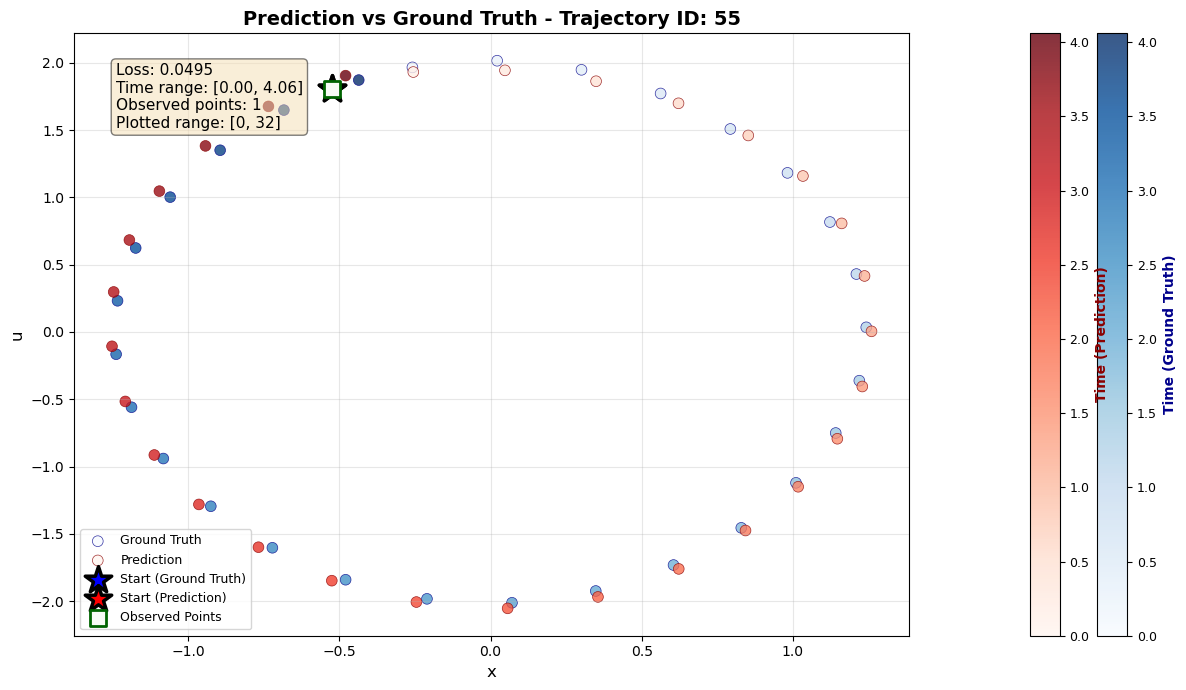

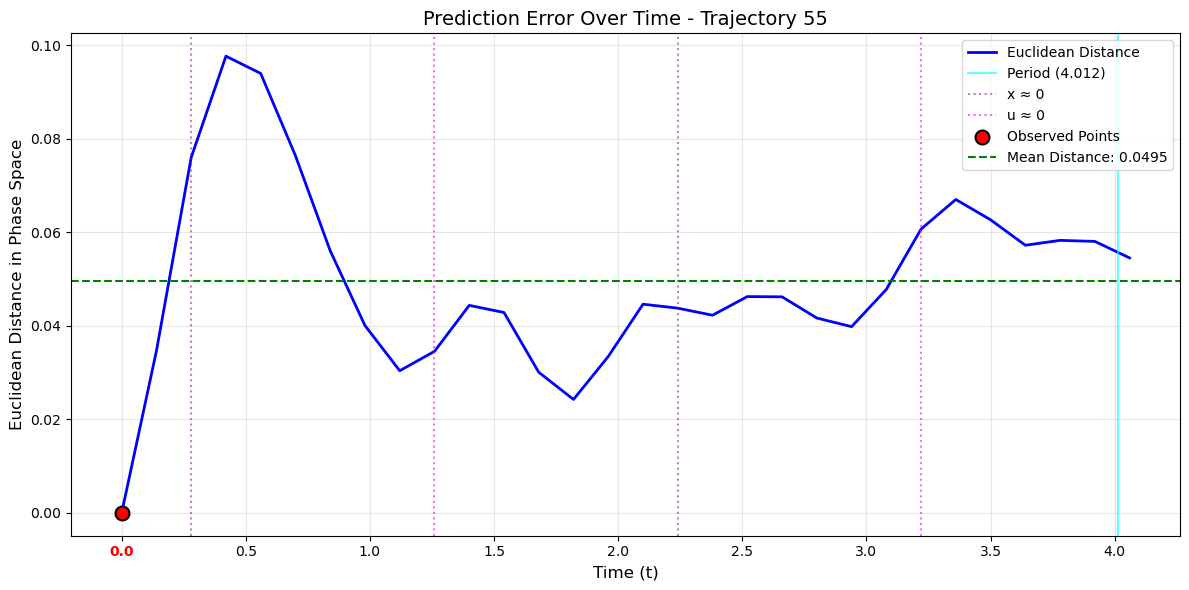

In [18]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples_pendulum, test_df=test_df_low_samples_pendulum, trajectory_id=trajectory_id_to_show_test, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period_test, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 3
inverse_net calls: 89
Total forward passes: 92
Coverage: 100.0%
Observed time points: [0.]


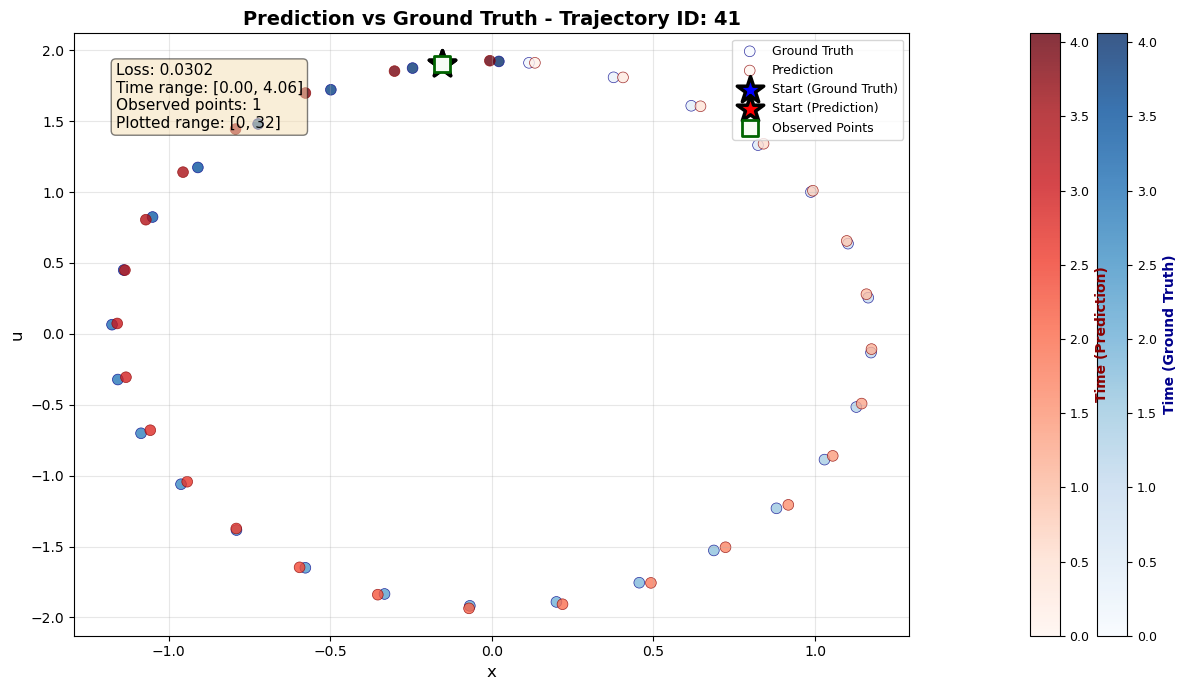

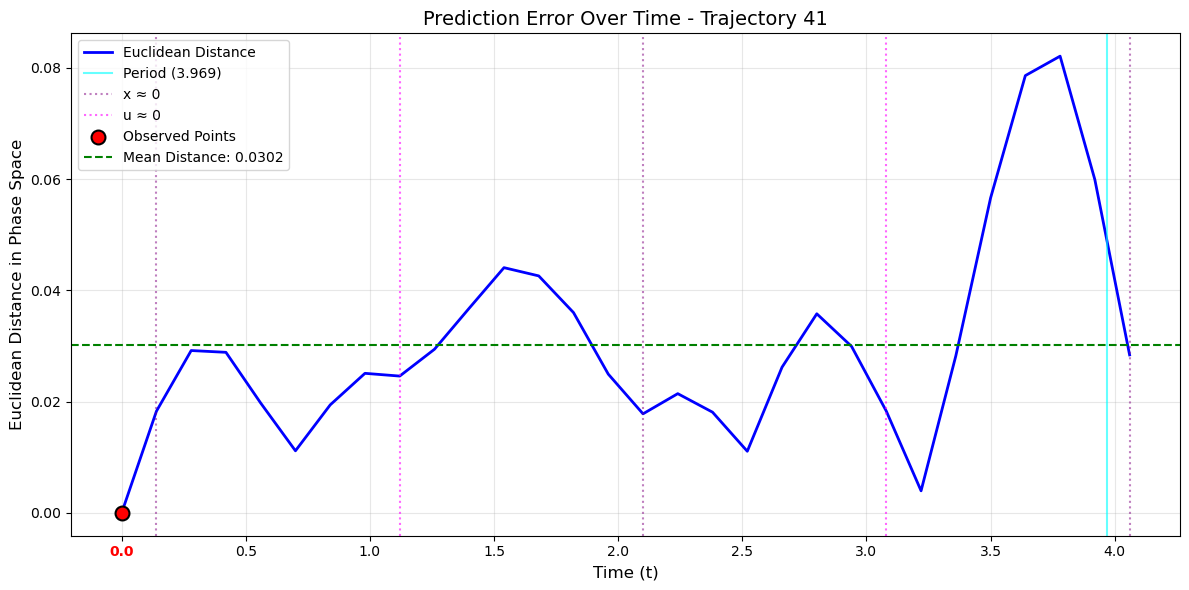

In [ ]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples_pendulum, test_df=test_df_low_samples_pendulum, trajectory_id=trajectory_id_to_show_test_ensemble, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period_test_ensemble, max_t_training=max_t_training, efficiently=False, method="gaussian_mixture_simple", threshold=0.5556654999491227, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=3, search_range_lower_pct=0.1, search_range_upper_pct=0.6092434547598503, verbose=True)

    trajectory_id  energy  prediction_loss  loss_per_sqrt_energy
0               0    1.30         0.699268              0.613299
1               1    1.35         0.569702              0.490322
2               2    1.40         0.697417              0.589425
3               3    1.45         0.523566              0.434798
4               4    1.50         0.636952              0.520069
5               5    1.55         0.597780              0.480149
6               6    1.60         0.521178              0.412028
7               7    1.65         0.221876              0.172730
8               8    1.70         0.243544              0.186790
9               9    1.75         0.354168              0.267726
10             10    1.80         0.404013              0.301134
11             11    1.85         0.322386              0.237023
12             12    1.90         0.274178              0.198909
13             13    1.95         0.329458              0.235930
14             14    2.00

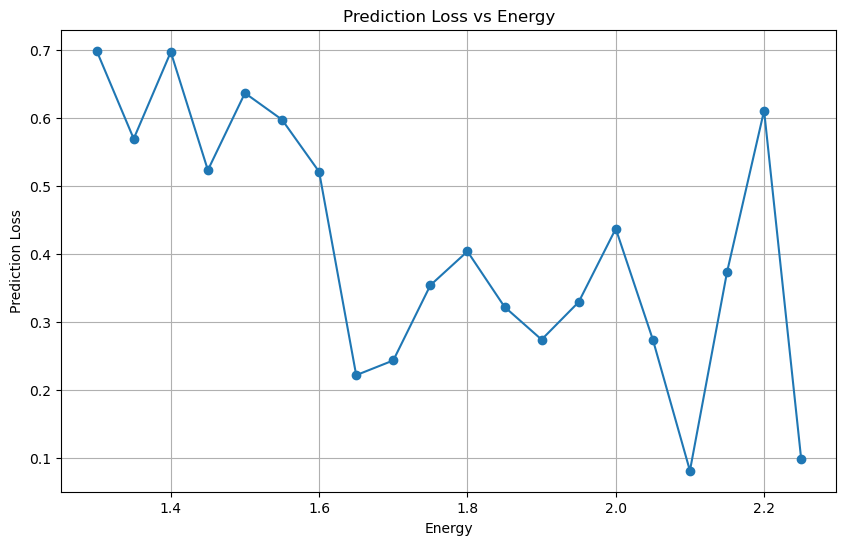

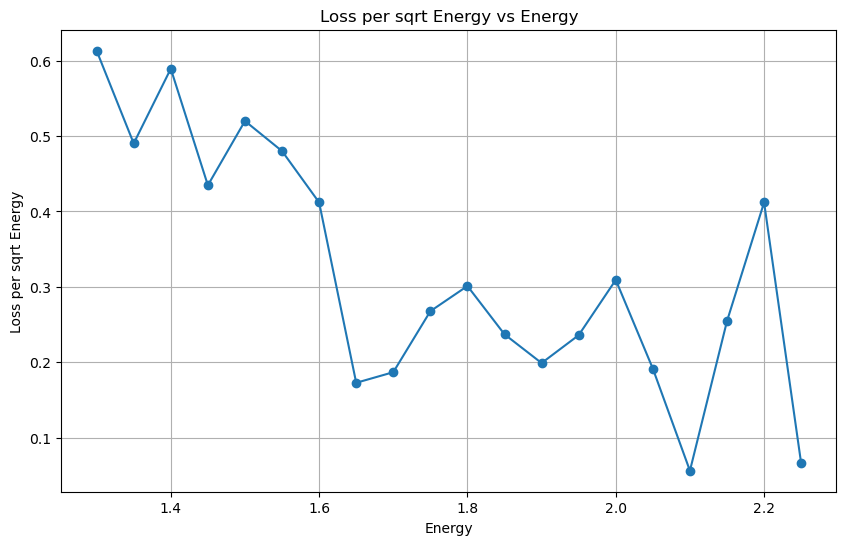

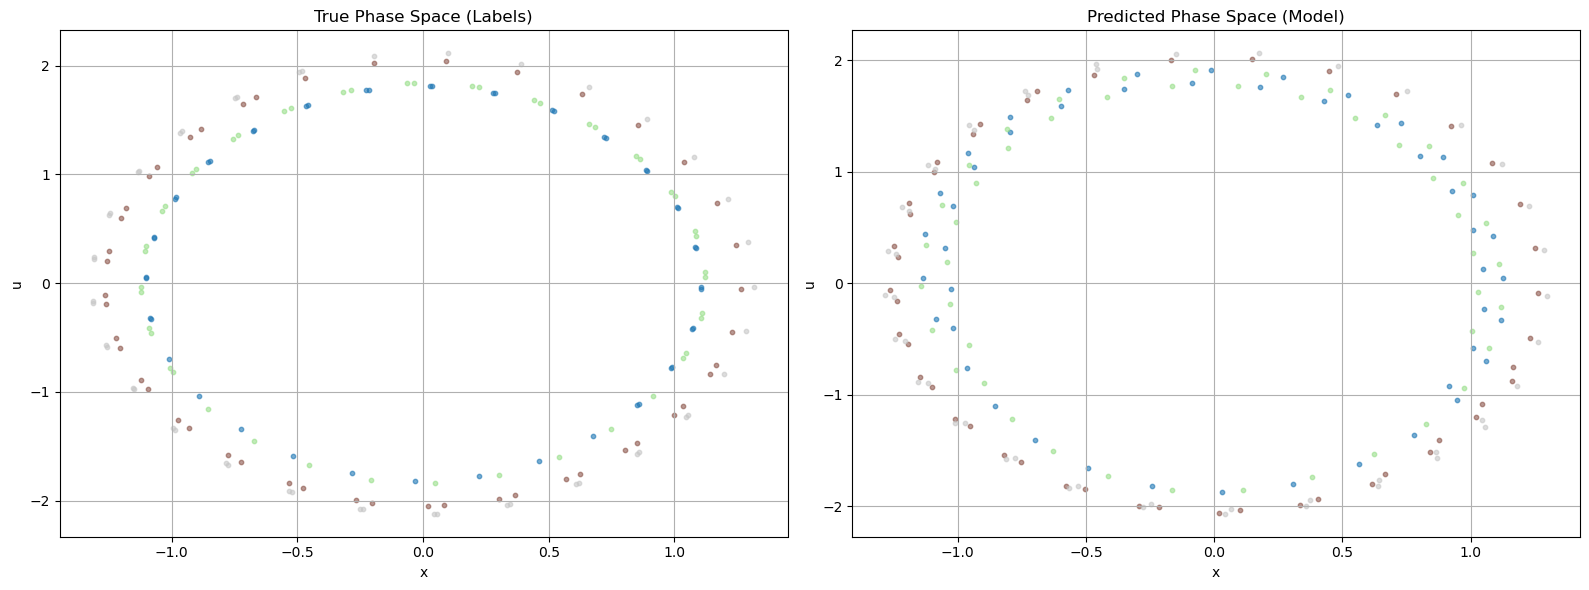

In [ ]:
prediction_test_df_multiple_periods, mean_prediction_loss_test_multiple_periods, pred_test_df_multiple_periods = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples_multiple_periods_pendulum, test_df=test_df_low_samples_multiple_periods_pendulum, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=0.3333, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

    trajectory_id  energy  prediction_loss  loss_per_sqrt_energy
0               0    1.30         0.534039              0.468383
1               1    1.35         0.525794              0.452531
2               2    1.40         0.454258              0.383918
3               3    1.45         0.430735              0.357706
4               4    1.50         0.374892              0.306098
5               5    1.55         0.311201              0.249962
6               6    1.60         0.292101              0.230926
7               7    1.65         0.322895              0.251373
8               8    1.70         0.268225              0.205719
9               9    1.75         0.199759              0.151003
10             10    1.80         0.105519              0.078650
11             11    1.85         0.082560              0.060699
12             12    1.90         0.070147              0.050890
13             13    1.95         0.077811              0.055722
14             14    2.00

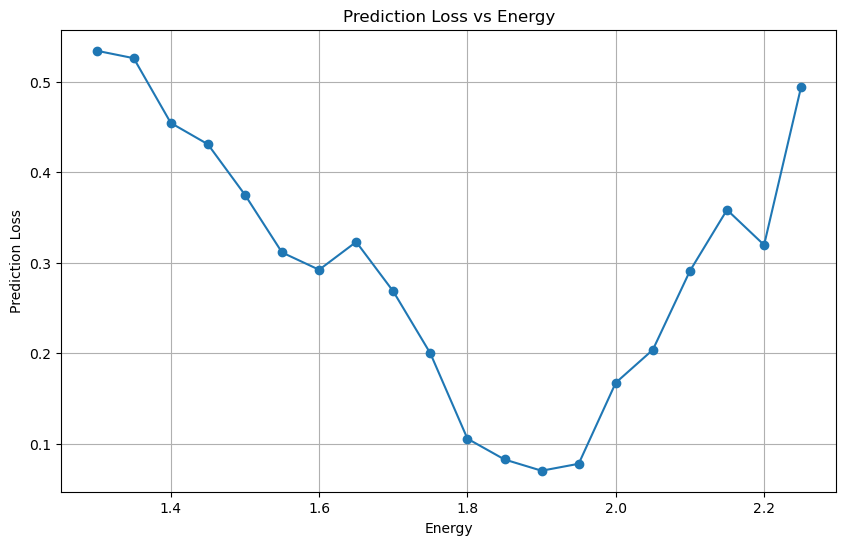

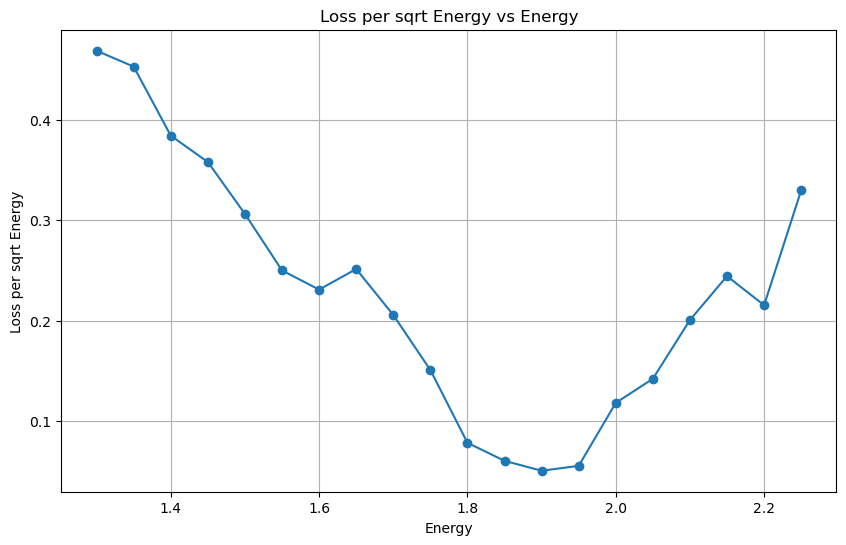

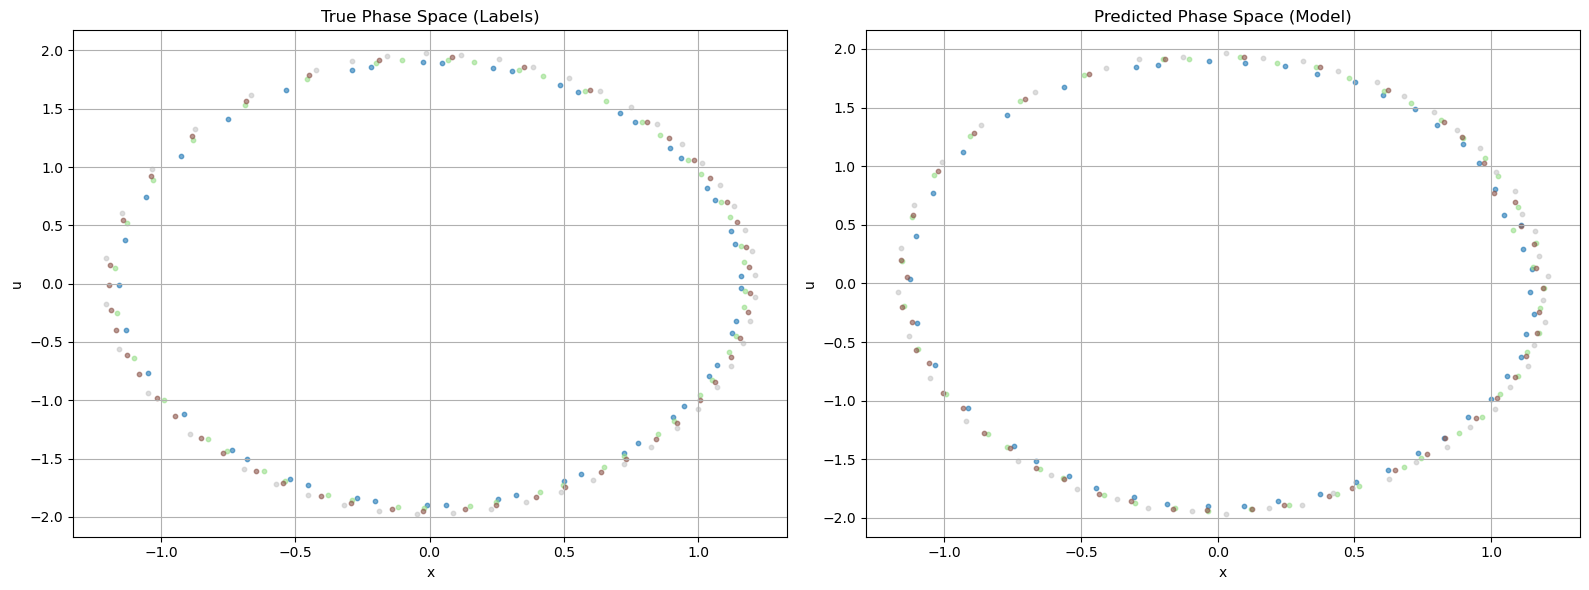

In [ ]:
prediction_test_ensemble_df_multiple_periods, mean_prediction_loss_test_ensemble_multiple_periods, pred_test_ensemble_df_multiple_periods = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples_multiple_periods_pendulum, test_df=test_df_low_samples_multiple_periods_pendulum, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=0.3333, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=False, method="gaussian_mixture_simple", threshold=0.5556654999491227, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=3, search_range_lower_pct=0.1, search_range_upper_pct=0.6092434547598503, verbose=True)

In [10]:
trajectory_id_test_multiple_periods = 16
period_test_multiple_periods = test_id_df_low_samples_multiple_periods_pendulum[test_id_df_low_samples_multiple_periods_pendulum['trajectory_id']==trajectory_id_test_multiple_periods]['period'].values[0] if test_id_df_low_samples_multiple_periods_pendulum[test_id_df_low_samples_multiple_periods_pendulum['trajectory_id']==trajectory_id_test_multiple_periods]['motion_type'].values[0] == "oscillating" else 0.0

trajectory_id_test_multiple_periods_ensemble = 12
period_test_multiple_periods_ensemble = test_id_df_low_samples_multiple_periods_pendulum[test_id_df_low_samples_multiple_periods_pendulum['trajectory_id']==trajectory_id_test_multiple_periods_ensemble]['period'].values[0] if test_id_df_low_samples_multiple_periods_pendulum[test_id_df_low_samples_multiple_periods_pendulum['trajectory_id']==trajectory_id_test_multiple_periods_ensemble]['motion_type'].values[0] == "oscillating" else 0.0


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 5
inverse_net calls: 5
Total forward passes: 10
Observed time points: [0.]


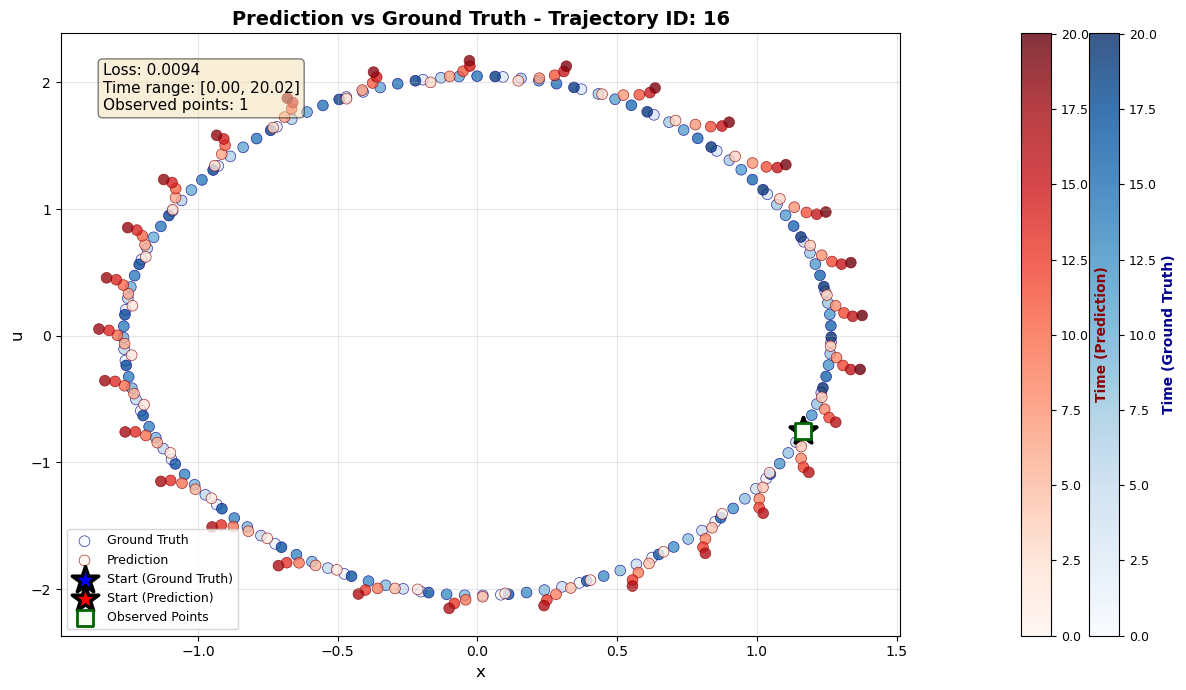

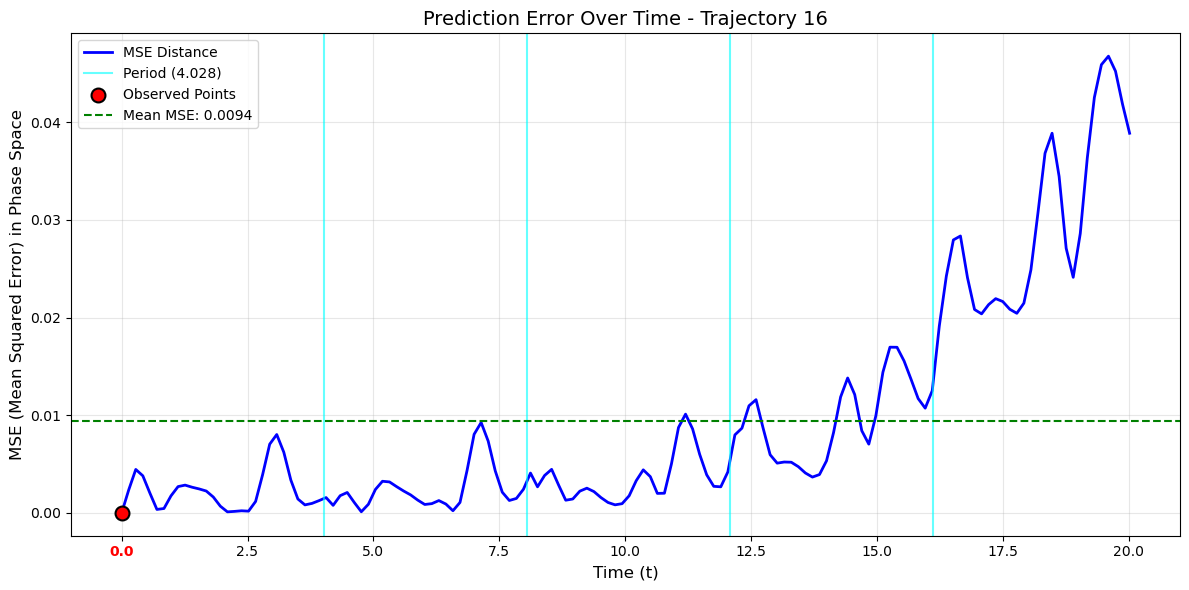

In [12]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, loss_type="mse", test_id_df=test_id_df_low_samples_multiple_periods_pendulum, test_df=test_df_low_samples_multiple_periods_pendulum, trajectory_id=trajectory_id_test_multiple_periods, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=None, show_zeroings=False, show_period=True, period=period_test_multiple_periods, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 15
inverse_net calls: 815
Total forward passes: 830
Coverage: 100.0%
Observed time points: [0.]


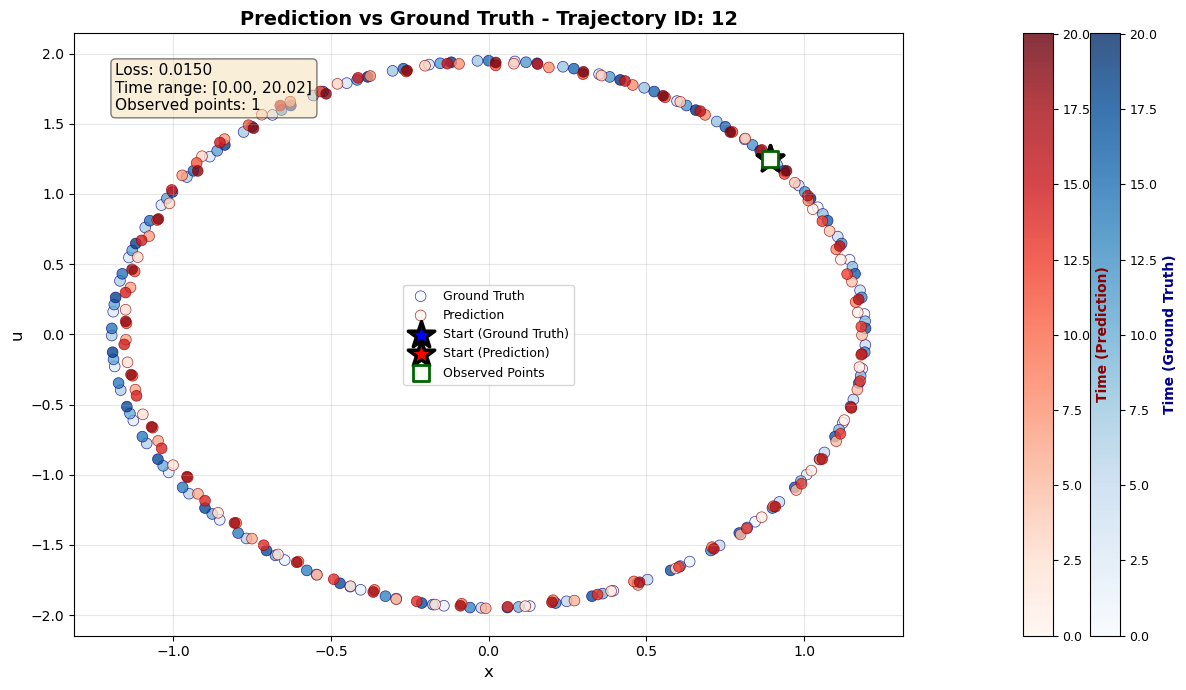

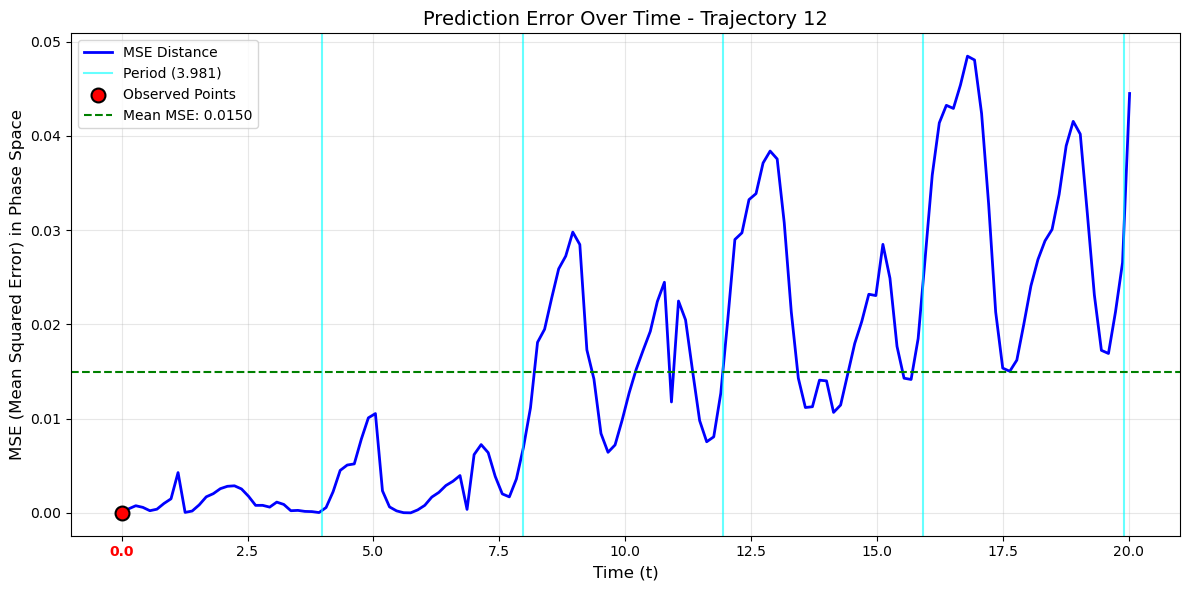

In [14]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, loss_type="mse", test_id_df=test_id_df_low_samples_multiple_periods_pendulum, test_df=test_df_low_samples_multiple_periods_pendulum, trajectory_id=trajectory_id_test_multiple_periods_ensemble, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=None, show_zeroings=False, show_period=True, period=period_test_multiple_periods_ensemble, max_t_training=max_t_training, efficiently=False, method="gaussian_mixture_simple", threshold=0.5556654999491227, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=3, search_range_lower_pct=0.1, search_range_upper_pct=0.6092434547598503, verbose=True)

In [237]:
print(f"The max energy of a trajectory in the training set is: {train_id_df_low_samples_pendulum['energy'].max():.3f}\nThe high energy testing set has energies in the range: {test_id_df_high_energy_low_samples_pendulum['energy'].min():.3f}-{test_id_df_high_energy_low_samples_pendulum['energy'].max():.3f}")

The max energy of a trajectory in the training set is: 2.287
The high energy testing set has energies in the range: 2.400-4.431


In [24]:
point_indexes_observed_high_energy = [0]


    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
0               0  2.400000         0.182757              0.117969
5               5  2.823077         0.241178              0.143541
6               6  2.907692         0.335755              0.196901
8               8  3.076923         0.306116              0.174513
10             10  3.246154         0.502261              0.278769
11             11  3.330769         0.389822              0.213596
13             13  3.500000         0.344613              0.184203
14             14  3.584615         0.375588              0.198376
17             17  3.838462         0.500630              0.255528
19             19  4.007692         0.573376              0.286412
20             20  4.092308         0.564003              0.278803
21             21  4.176923         0.615951              0.301383
24             24  4.430769         0.719195              0.341670
Mean prediction loss over full dataframe: 0.4347


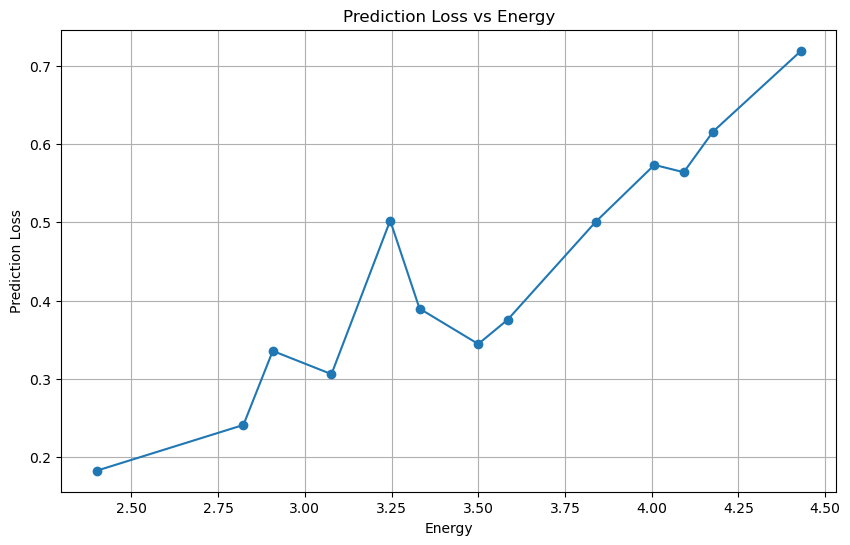

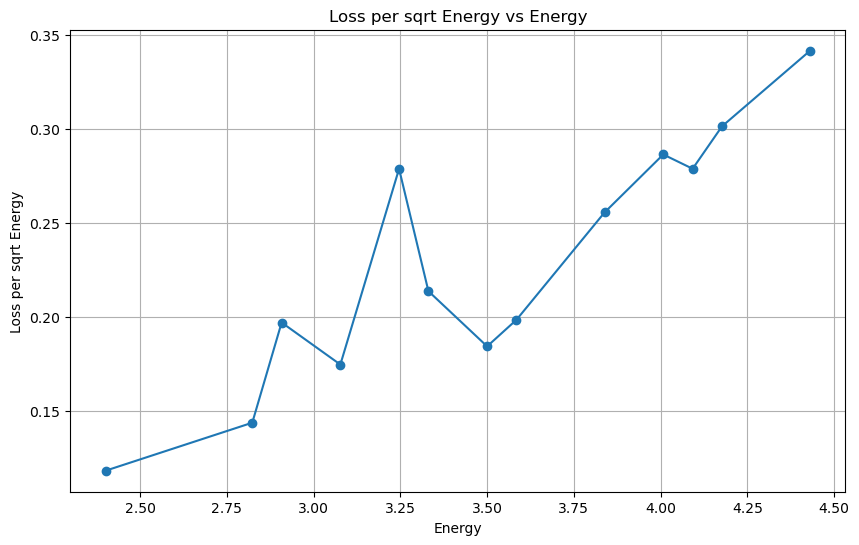

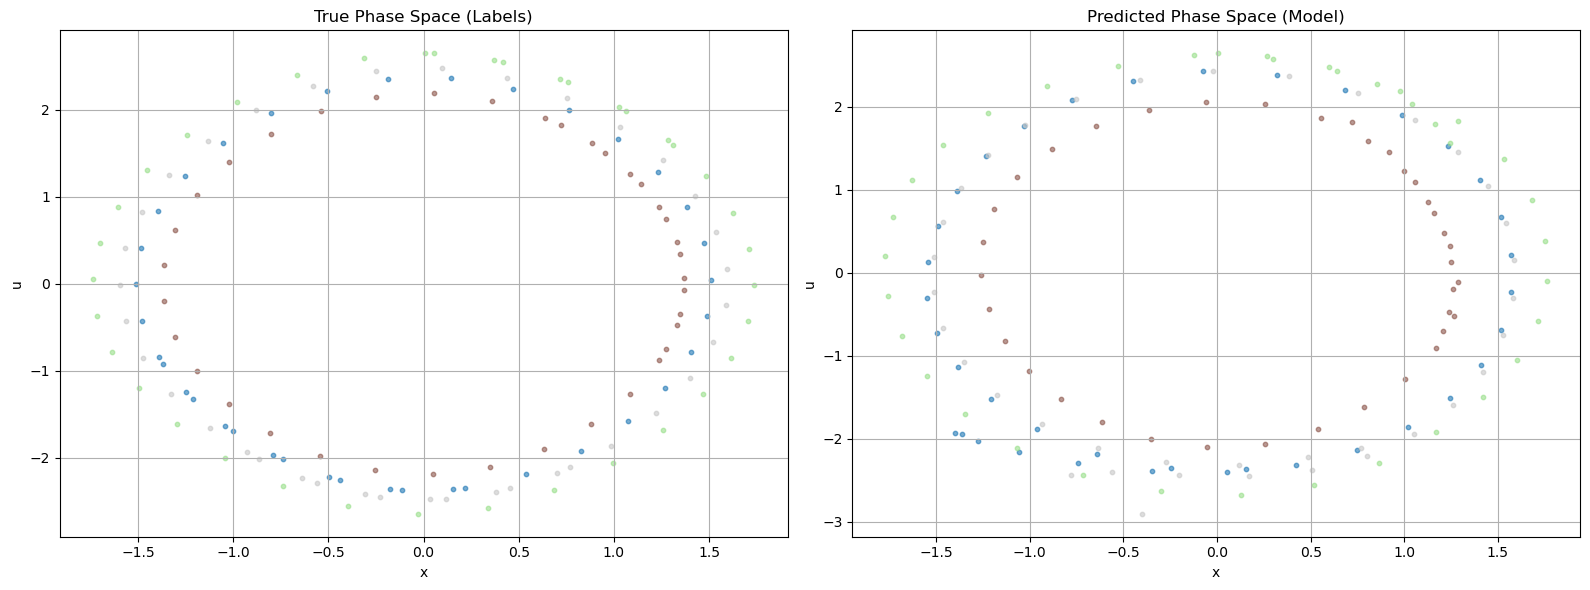

In [ ]:
prediction_test_high_energy_df, mean_prediction_loss_test_high_energy, pred_test_high_energy_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_low_samples_pendulum, test_df=test_df_high_energy_low_samples_pendulum, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.3, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
0               0  2.400000         0.118052              0.076202
5               5  2.823077         0.307826              0.183208
6               6  2.907692         0.401924              0.235706
8               8  3.076923         0.458230              0.261231
10             10  3.246154         0.520007              0.288619
11             11  3.330769         0.561790              0.307824
13             13  3.500000         0.691785              0.369775
14             14  3.584615         0.588293              0.310722
17             17  3.838462         0.820980              0.419039
19             19  4.007692         1.024240              0.511628
20             20  4.092308         0.961107              0.475103
21             21  4.176923         0.998954              0.488784
24             24  4.430769         1.003626              0.476796
Mean prediction loss over full dataframe: 0.6505


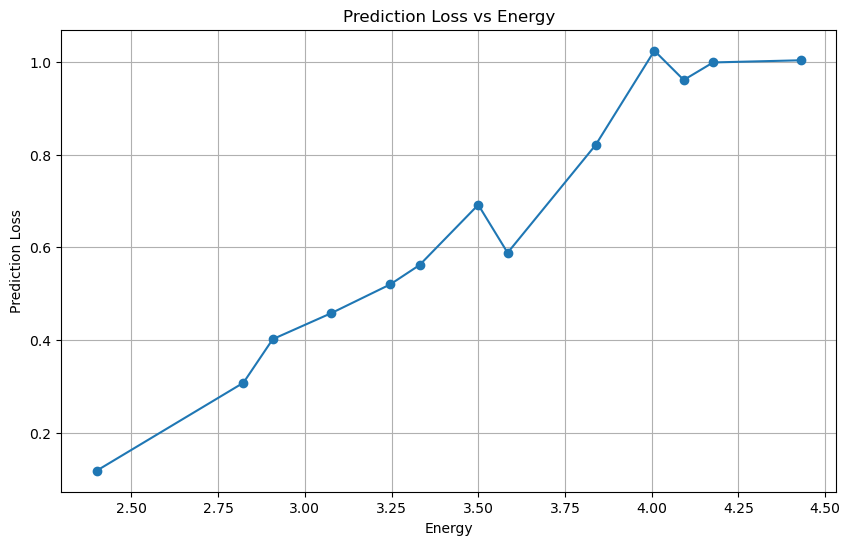

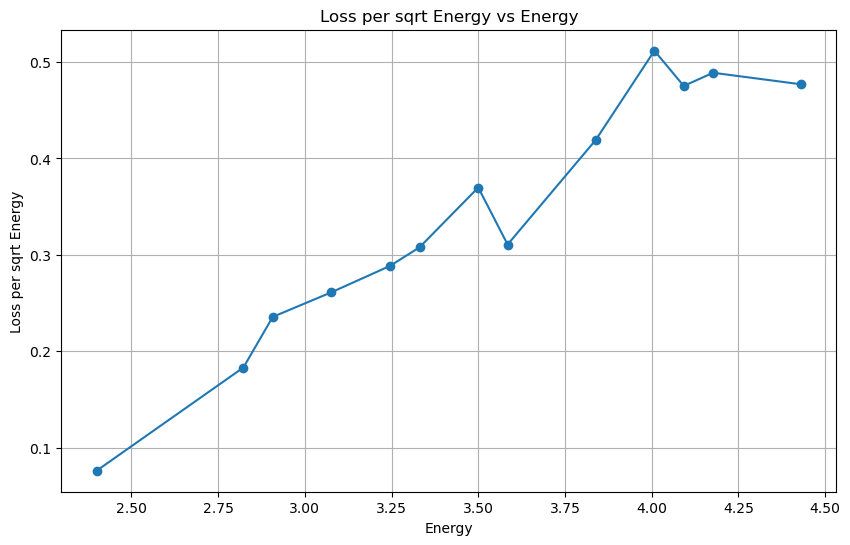

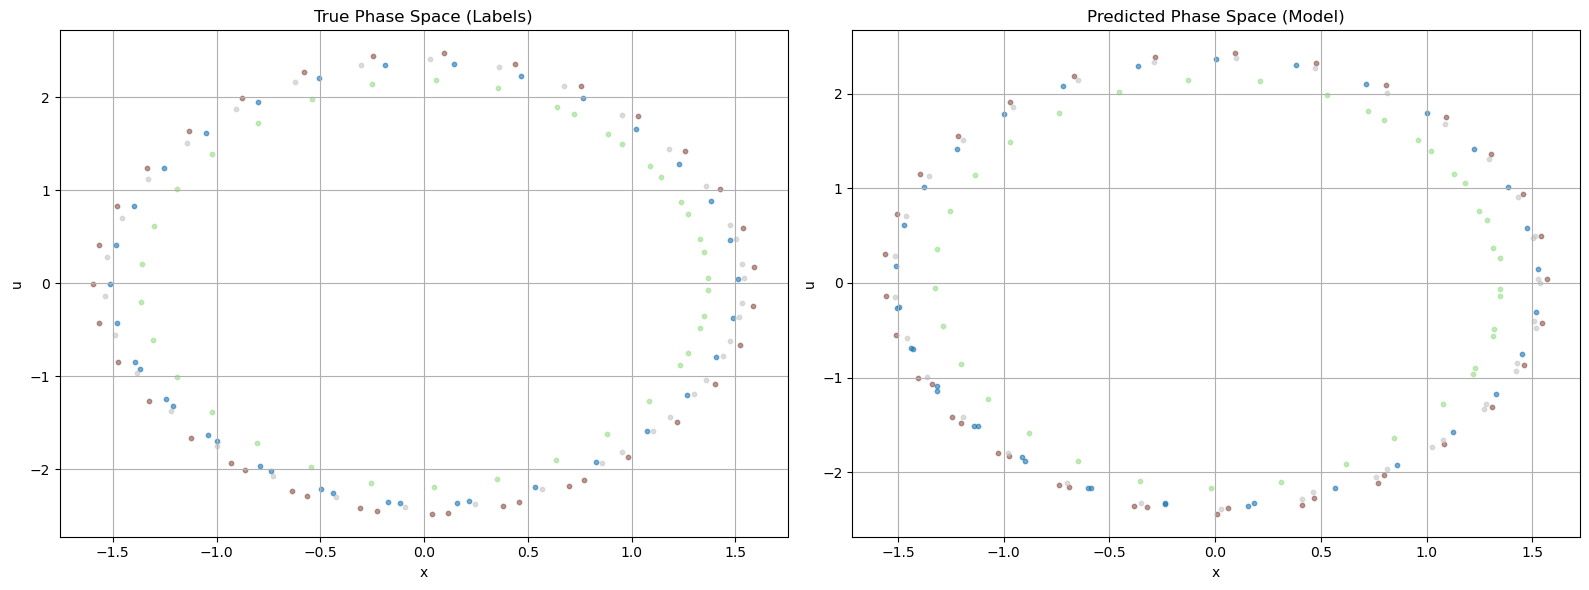

In [ ]:
prediction_test_ensemble_high_energy_df, mean_prediction_loss_test_ensemble_high_energy, pred_test_ensemble_high_energy_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_low_samples_pendulum, test_df=test_df_high_energy_low_samples_pendulum, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.3, max_t_training=max_t_training, efficiently=False, method="gaussian_mixture_simple", threshold=0.5556654999491227, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=3, search_range_lower_pct=0.1, search_range_upper_pct=0.6092434547598503, verbose=True)

    trajectory_id    energy  variance_loss  variance_per_sqrt_energy
0               0  2.400000            0.0                       0.0
5               5  2.823077            0.0                       0.0
6               6  2.907692            0.0                       0.0
8               8  3.076923            0.0                       0.0
10             10  3.246154            0.0                       0.0
11             11  3.330769            0.0                       0.0
13             13  3.500000            0.0                       0.0
14             14  3.584615            0.0                       0.0
17             17  3.838462            0.0                       0.0
19             19  4.007692            0.0                       0.0
20             20  4.092308            0.0                       0.0
21             21  4.176923            0.0                       0.0
24             24  4.430769            0.0                       0.0
Mean prediction loss over full dat

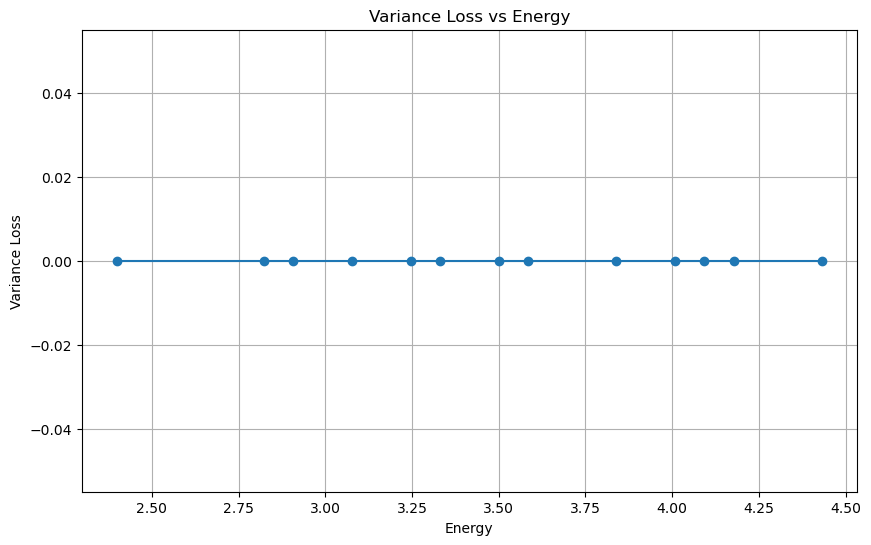

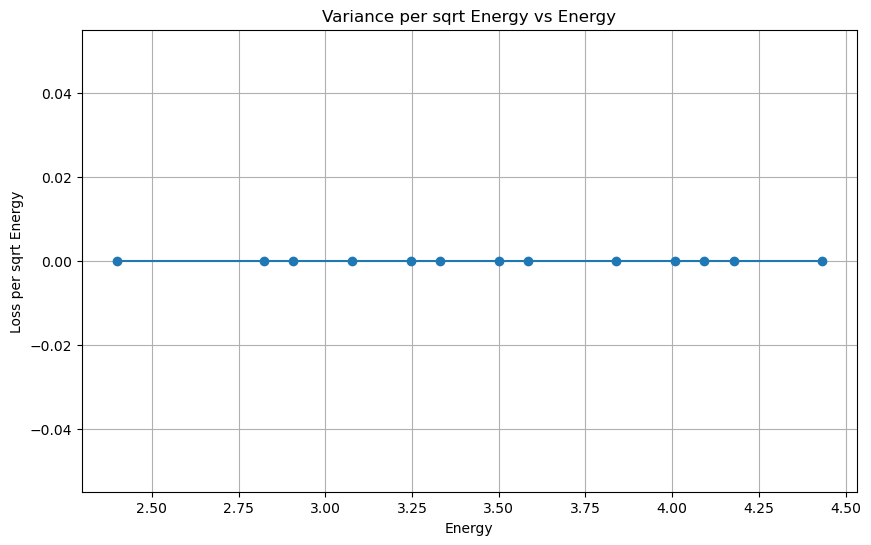

In [87]:
variance_test_high_energy_df, mean_variance_loss_test_high_energy = test_model_variance_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, test_id_df=test_id_df_high_energy_low_samples_pendulum, test_df=test_df_high_energy_low_samples_pendulum, mapping_net=mapping_net, device=device, point_indexes_observed=point_indexes_observed_high_energy)


In [26]:
trajectory_id_to_show_test_high_energy=14
period_test_high_energy = test_id_df_high_energy_low_samples_pendulum[test_id_df_high_energy_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_high_energy]['period'].values[0] if test_id_df_high_energy_low_samples_pendulum[test_id_df_high_energy_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_high_energy]['motion_type'].values[0] == "oscillating" else 0.0

trajectory_id_to_show_test_high_energy_ensemble=14
period_test_high_energy_ensemble = test_id_df_high_energy_low_samples_pendulum[test_id_df_high_energy_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_high_energy_ensemble]['period'].values[0] if test_id_df_high_energy_low_samples_pendulum[test_id_df_high_energy_low_samples_pendulum['trajectory_id']==trajectory_id_to_show_test_high_energy_ensemble]['motion_type'].values[0] == "oscillating" else 0.0


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 2
inverse_net calls: 2
Total forward passes: 4
Observed time points: [0.]


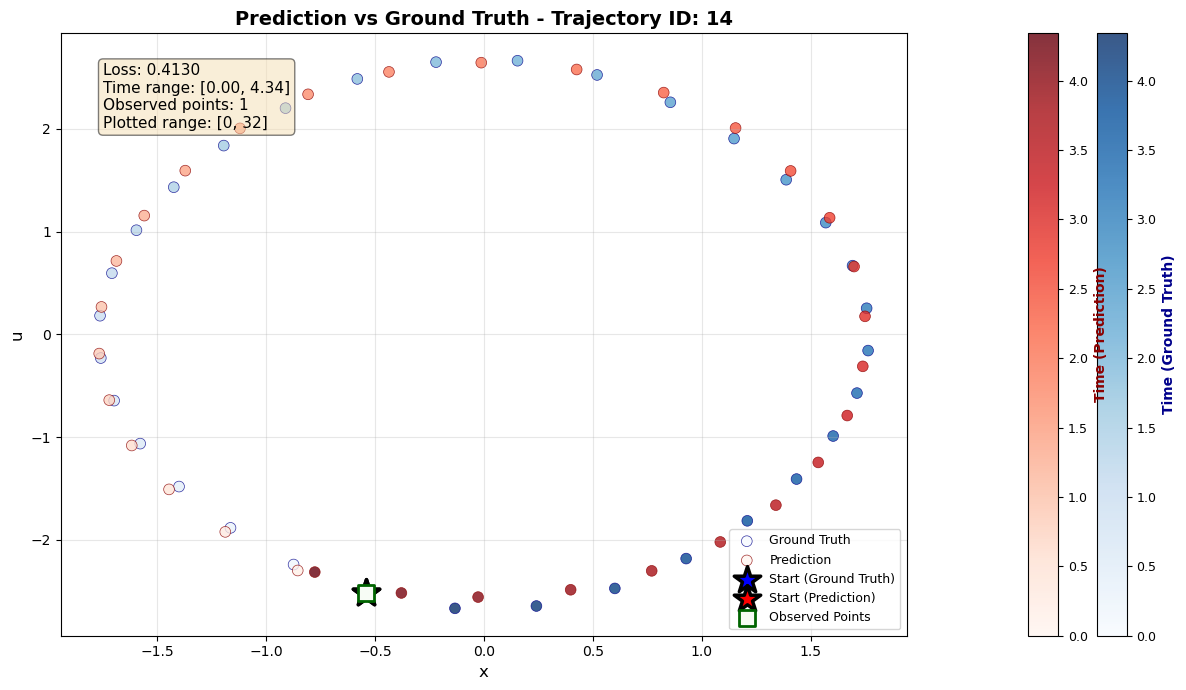

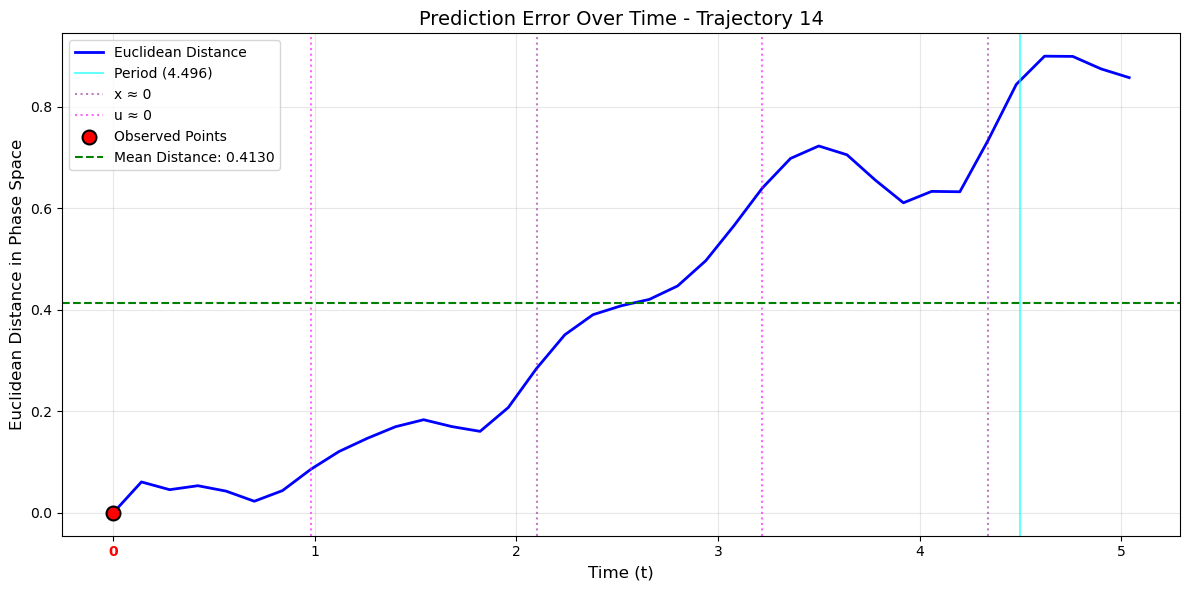

In [27]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_low_samples_pendulum, test_df=test_df_high_energy_low_samples_pendulum, trajectory_id=trajectory_id_to_show_test_high_energy, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period_test_high_energy, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 4
inverse_net calls: 140
Total forward passes: 144
Coverage: 100.0%
Observed time points: [0.]


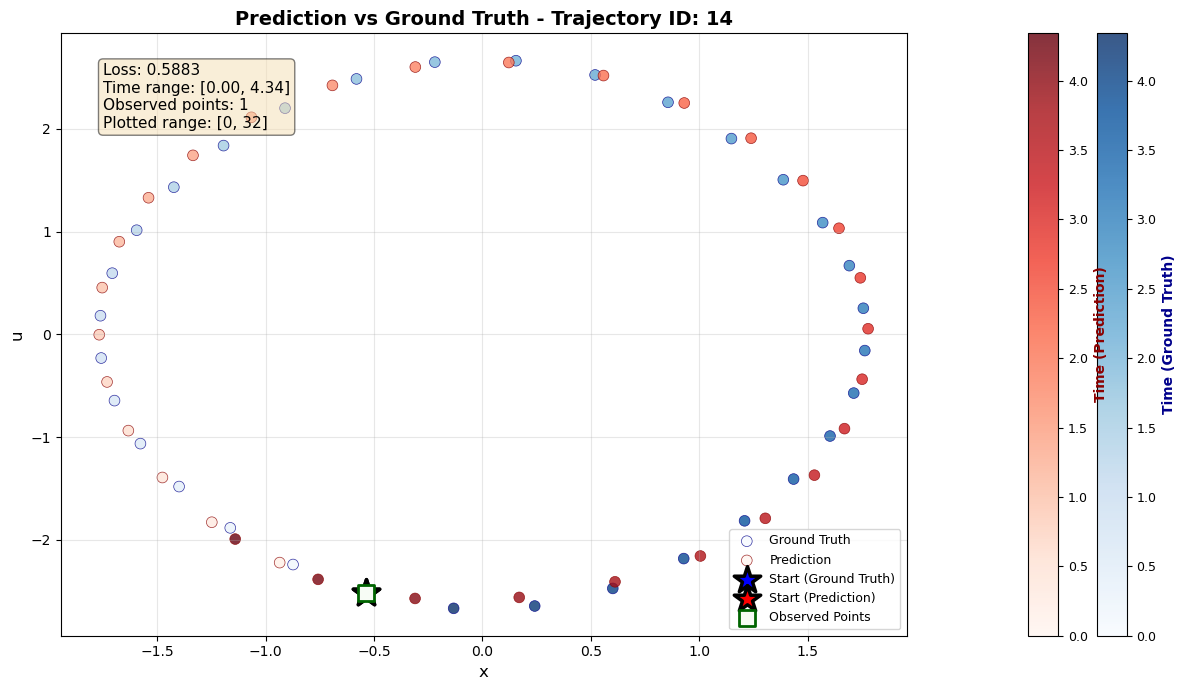

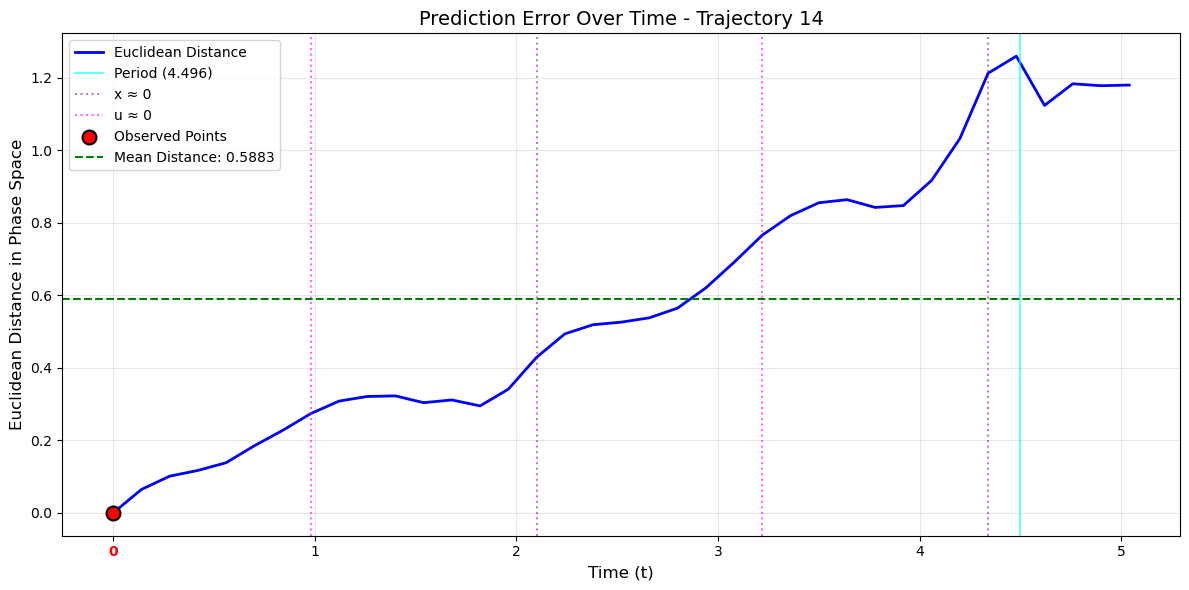

In [ ]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_low_samples_pendulum, test_df=test_df_high_energy_low_samples_pendulum, trajectory_id=trajectory_id_to_show_test_high_energy_ensemble, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period_test_high_energy_ensemble, max_t_training=max_t_training, efficiently=False, method="gaussian_mixture_simple", threshold=0.5556654999491227, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=3, search_range_lower_pct=0.1, search_range_upper_pct=0.6092434547598503, verbose=True)

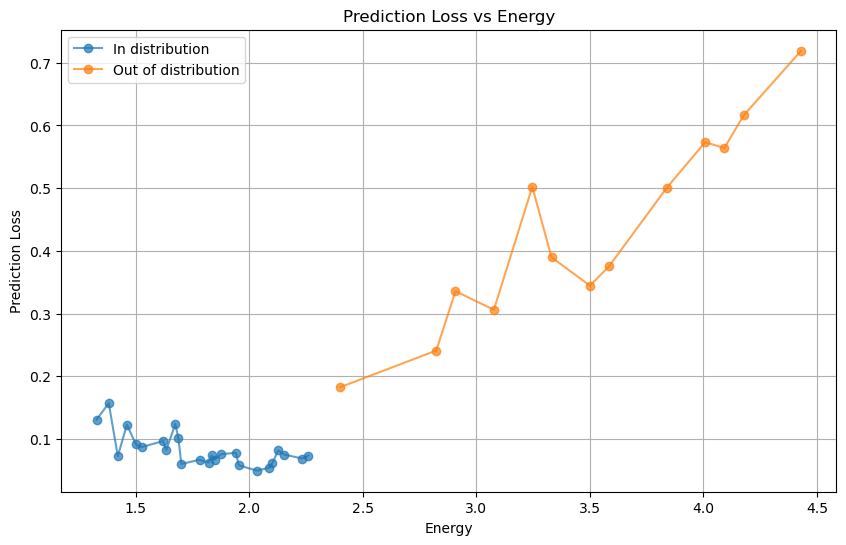

In [240]:
plot_prediction_losses([prediction_test_df, prediction_test_high_energy_df])

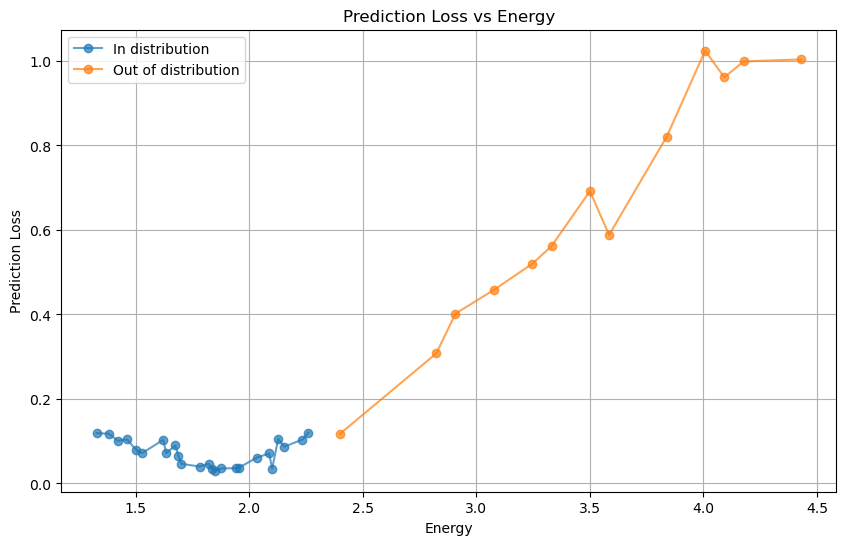

In [29]:
plot_prediction_losses([prediction_test_ensemble_df, prediction_test_ensemble_high_energy_df])

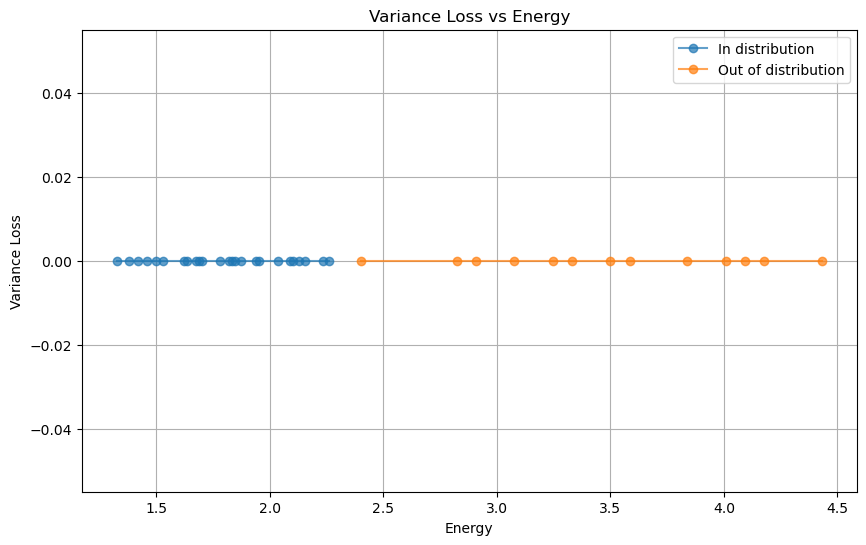

In [91]:
plot_variance_losses([variance_test_df, variance_test_high_energy_df])

Step 1 gamma values mean: 0.641±0.170

Step 2 gamma values mean: 0.658±0.178



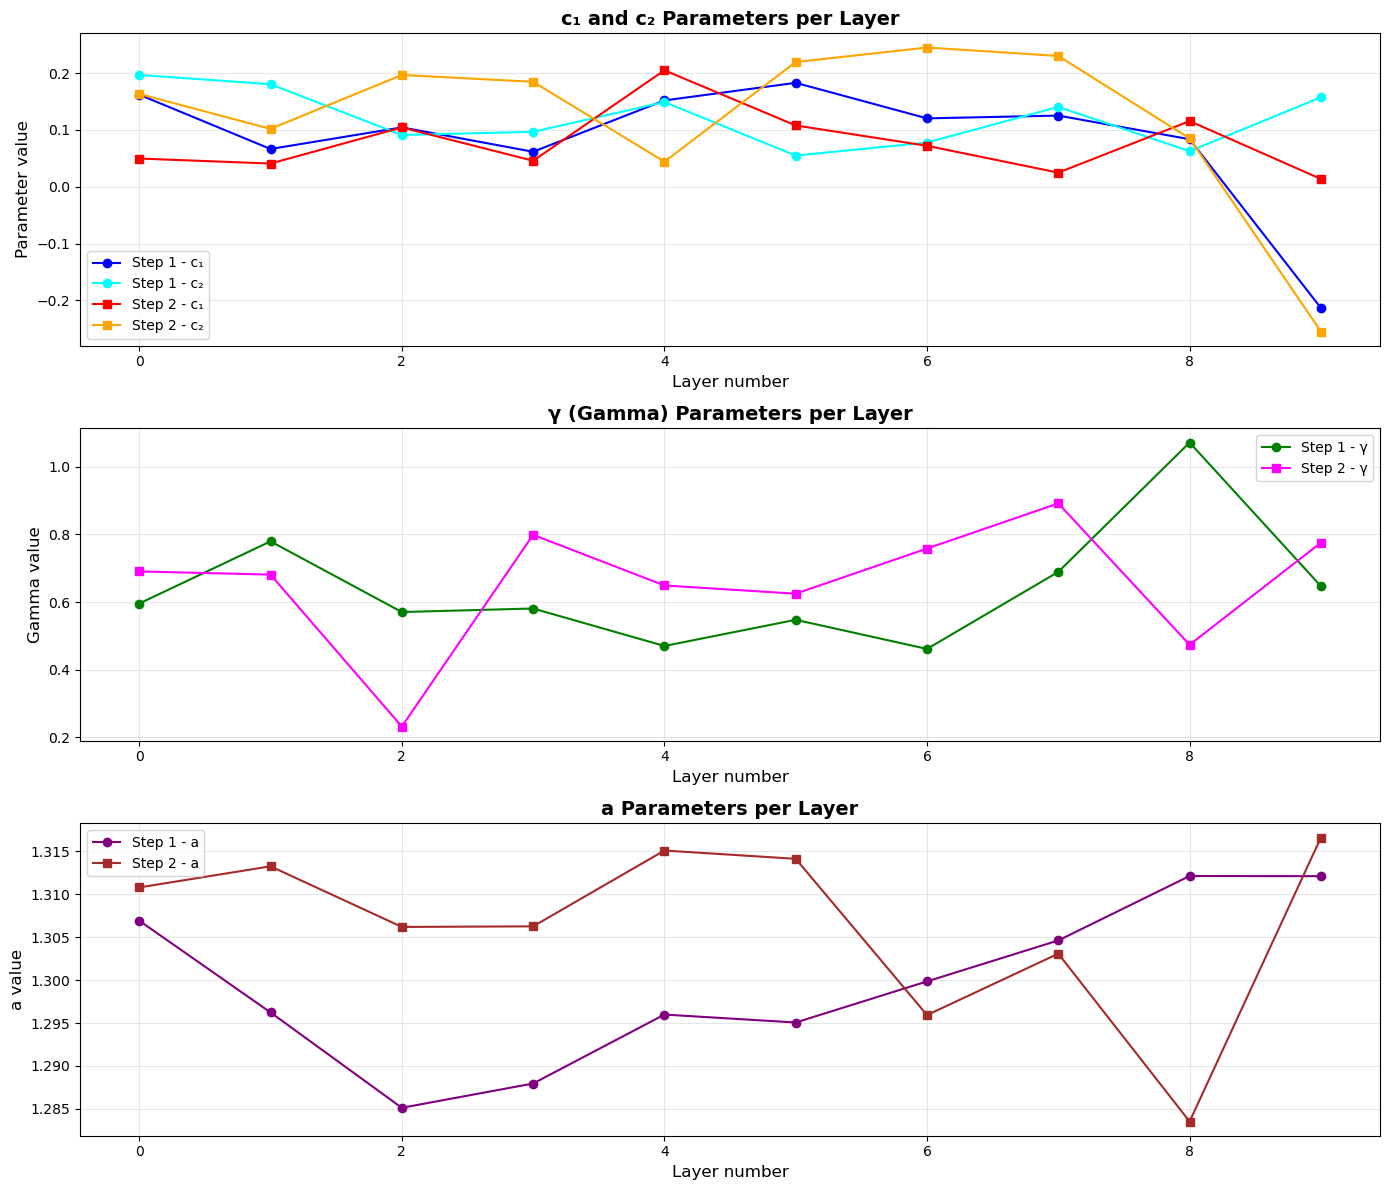

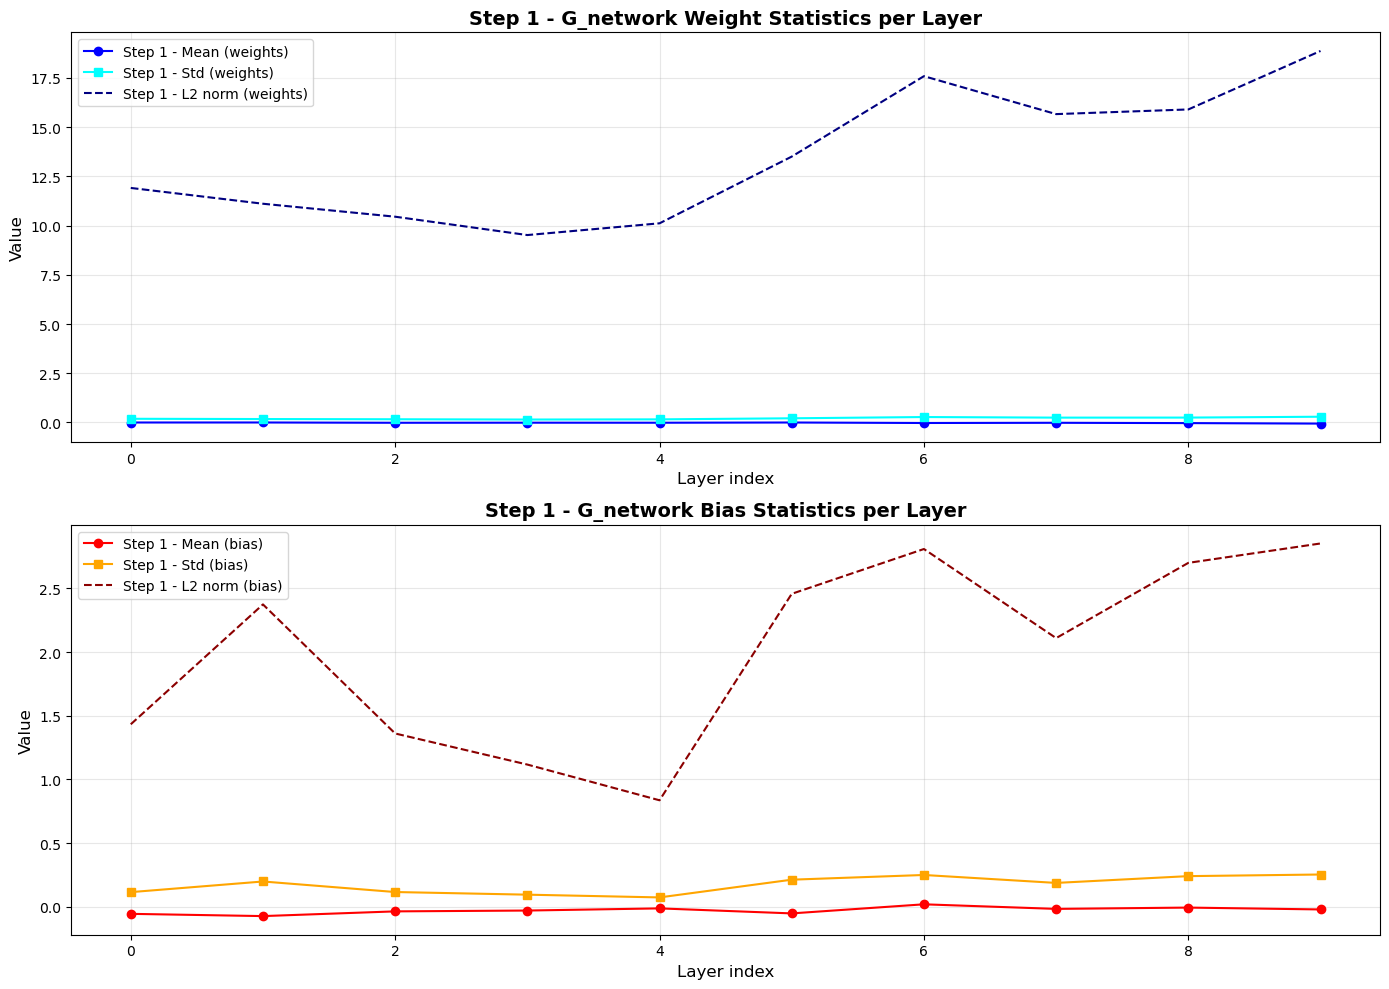

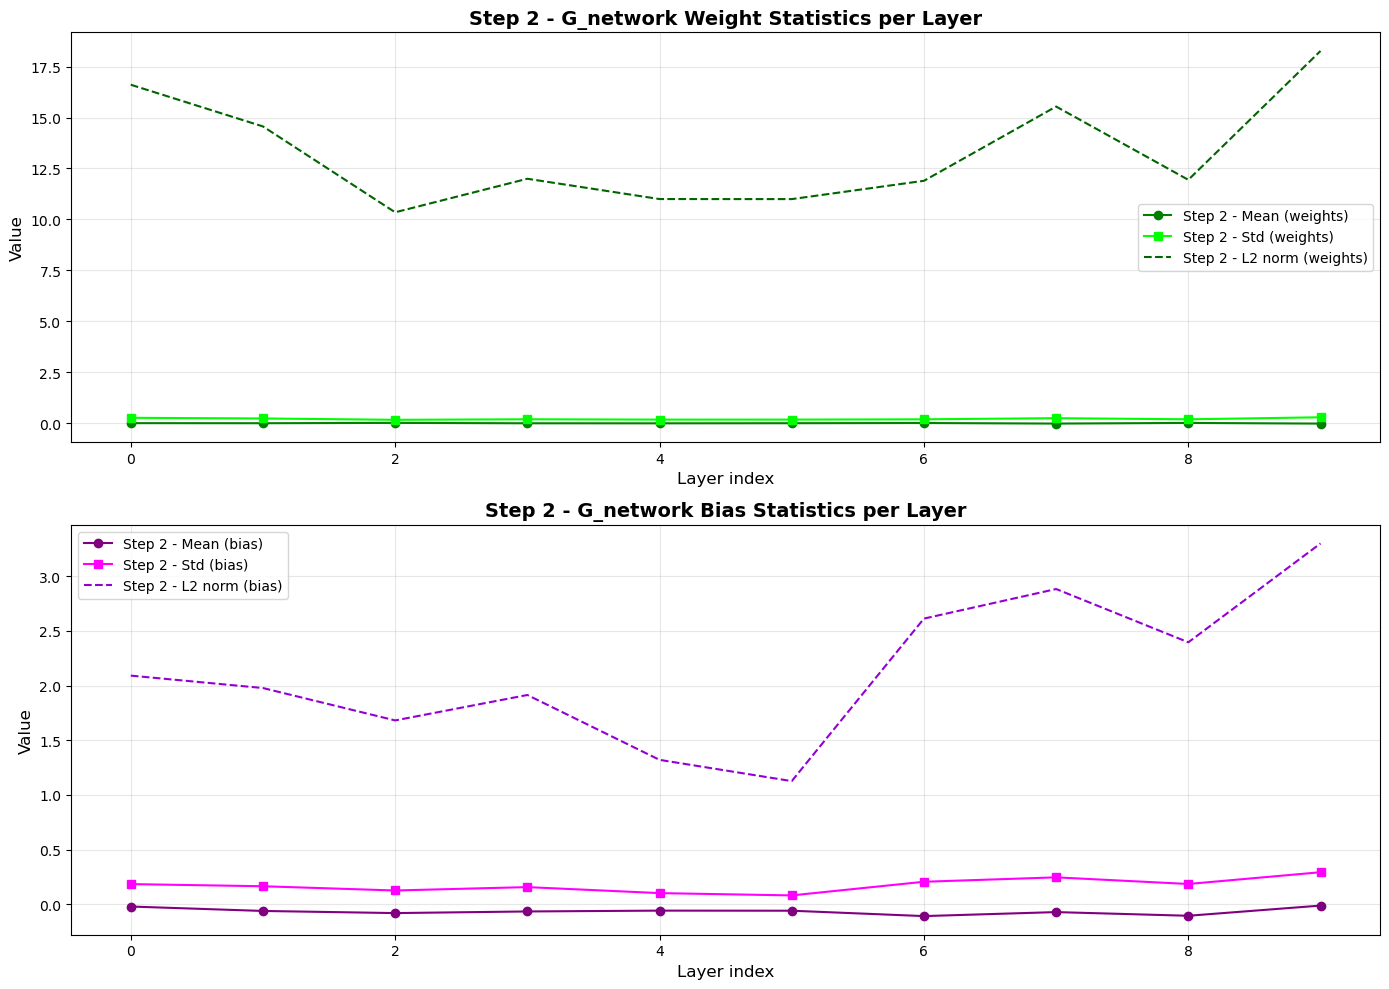

In [92]:
param_data = analyze_mapping_net(mapping_net, return_lists=True)
